# Исследование рынка недвижимости Санкт-Петербурга

**Цель проекта**


Исследование проводится с целью решения проблемы прогнозирования цен на объекты недвижимости. Главной задачей проекта является передача характеризующих объекты недвижимости параметров, которые могут быть использованы для прогнозирования стоимости объектов. 
Необходимо подтвердить или опровергнуть связь цены объекта с имеющимися в массиве данных параметрами, а также рассчитать дополнительные параметры и проверить связь с ними.

**Исходные данные**


Используемый массив данных -- это архив сервиса Яндекс Недвижимость за несколько лет по Санкт-Петербургу и ближайшим населенным пунктам. Массив данных передан в виде файла типа `.csv` и содержит параметры, заданные пользователями (стоимость, этаж, площадь и др.), а также картографические параметры (расстояние до центра города, наличие поблизости парков и др.)

## План работ

- Чтение данных и первичный анализ массива данных
- Предобработка данных
    - Работа с пропусками
    - Преобразование типов данных
    - Обработка неявных дубликатов
    - Изучение аномальных значений
- Расчет дополнительных параметров:
    - Цена одного квадратного метра
    - День недели публикации объявления
    - Месяц публикации объявления
    - Год публикации объявления
    - Тип этажа квартиры (первый, последний, другой)
    - Расстояние до центра города в километрах
- Исследовательский анализ данных:
    - Изучение параметров объектов
    - Анализ скорости продажи объектов
    - Факторы влияния на стоимость объекта
    - Стоимость квадратного метра по населенным пунктам
    - Средняя стоимость километра от центра в Санкт-Петербурге
- Общий вывод

## Чтение данных и импорт библиотек

In [1]:
# pandas
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:,.2f}'.format

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/Users/ilatti/Documents/practicum/3_third_sprint/project/real_estate_data.csv', sep="\t")

In [3]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

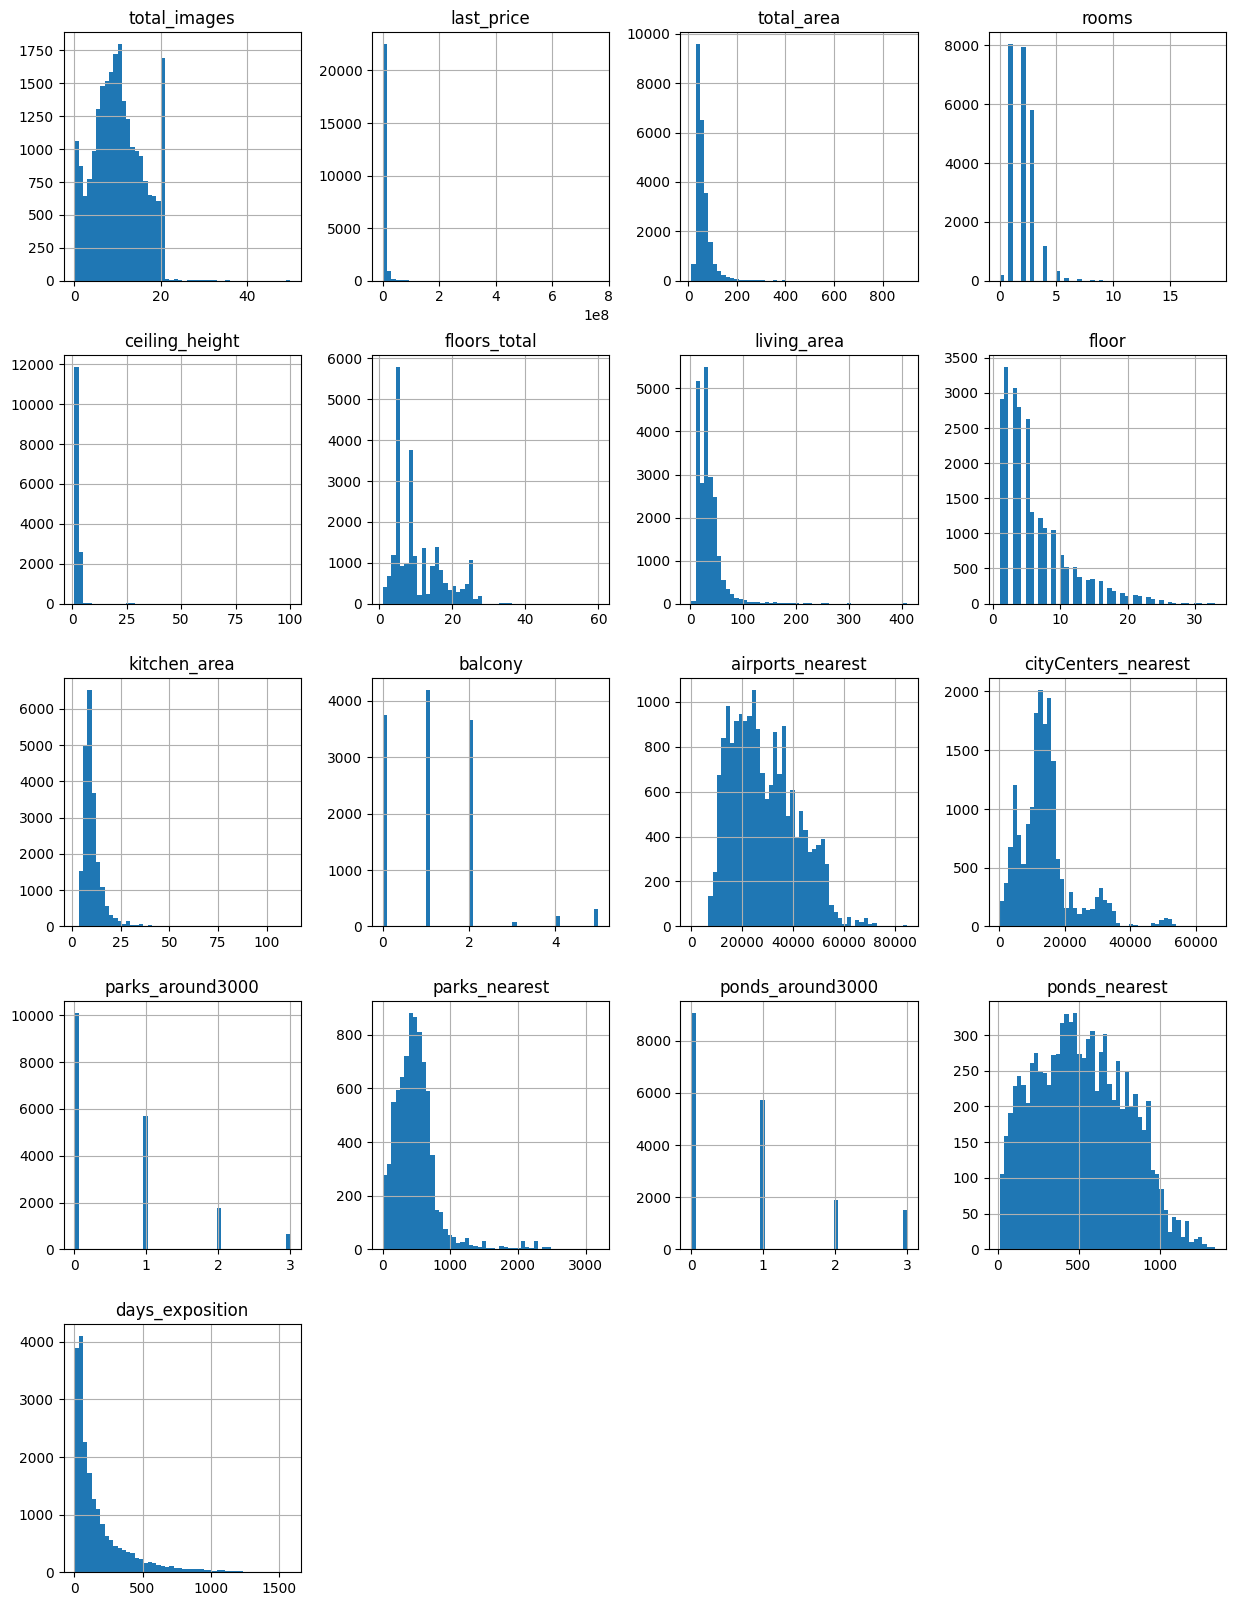

In [5]:
df.hist(figsize=(15, 20), bins=50);

**Вывод:** 
Данные считались корректно. Результирующий датафрейм имеет 22 столбца и ~ 24 тыс. строк.

Датафрейм необходимо предобработать: часть столбцов имеет пропуски, а некоторые столбцы имеют не самый удачный тип данных 

## Предобработка данных

### Пропуски в данных

Столбцы с пропусками: 

In [6]:
# missing values visualization function

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, legend = False, fontsize = 16, grid = False)
            .set_title('Доля пропусков по столбцам, %' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

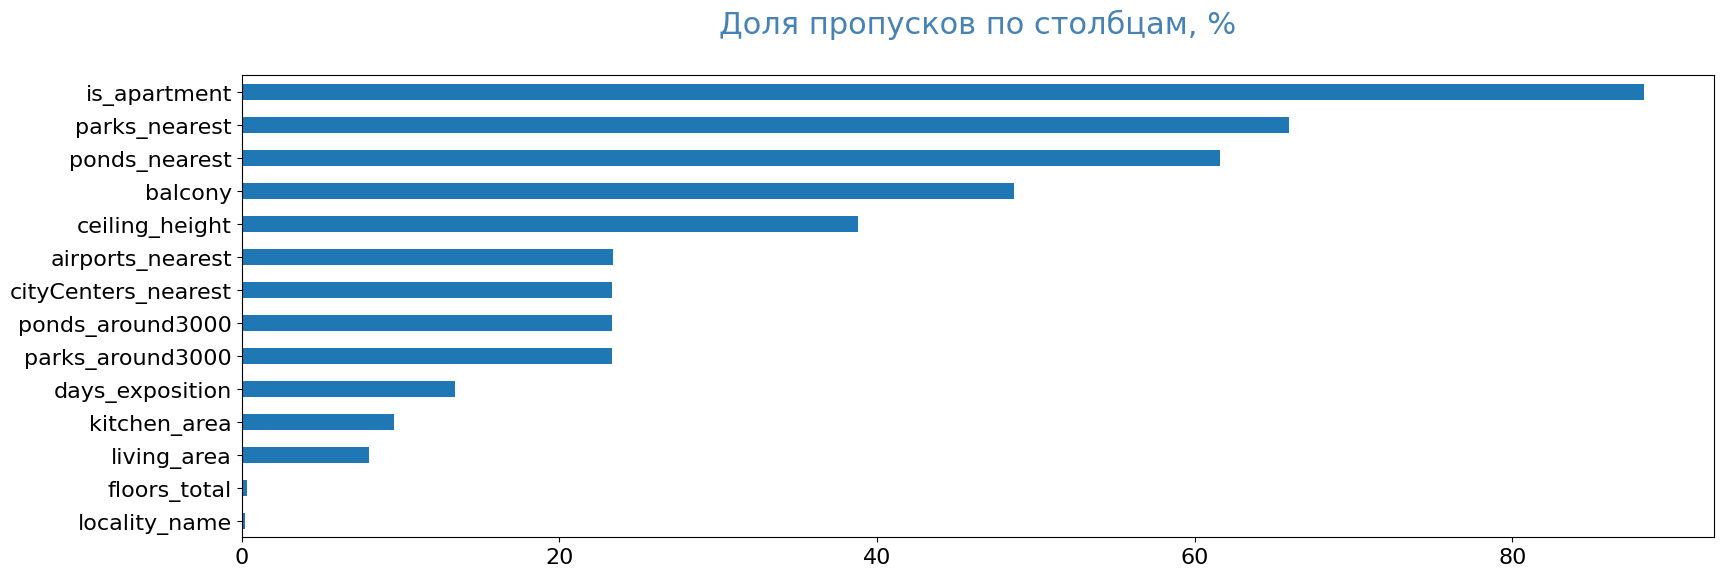

In [7]:
pass_value_barh(df)

Рассчитаем коэффициенты корреляции для выявления связей между столбцами данных и выясним, сможем ли мы заполнить пропуски на основании имеющейся информации:

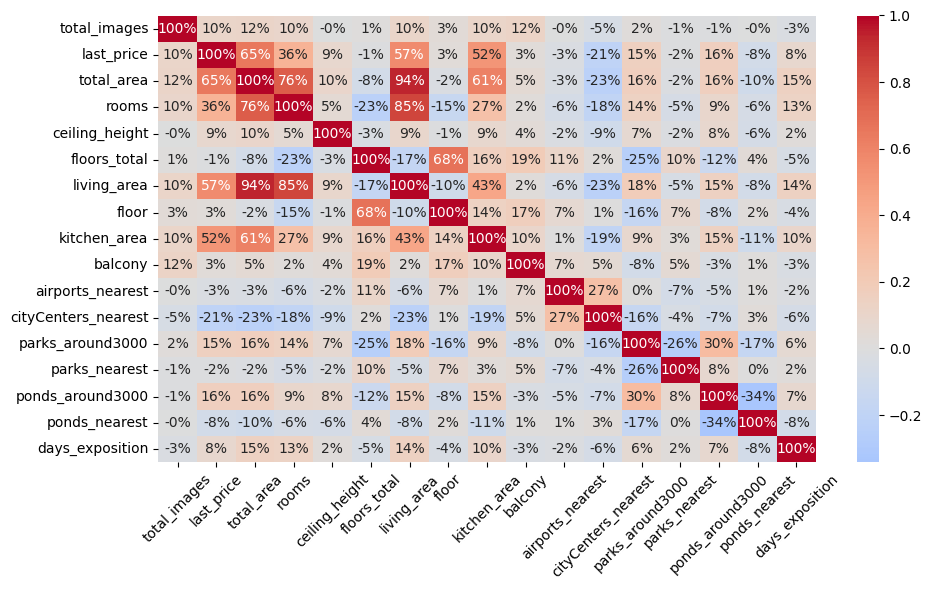

In [8]:
numerical_cols = ['total_images',
                 'last_price',
                 'total_area',
                 'rooms',
                 'ceiling_height',
                 'floors_total',
                 'living_area',
                 'floor',
                 'kitchen_area',
                 'balcony',
                 'airports_nearest',
                 'cityCenters_nearest',
                 'parks_around3000',
                 'parks_nearest',
                 'ponds_around3000',
                 'ponds_nearest',
                 'days_exposition']


fig, ax = plt.subplots()
fig.set(size_inches=(10, 6), tight_layout=True)

sns.heatmap(df[numerical_cols].corr(), annot=True, fmt='.0%', cmap='coolwarm', center=0, ax=ax);
plt.xticks(rotation=45);

Из показателей с пропусками видим отличную корреляцию между жилой площадью и общей площадью, значит между величинами существует почти линейная зависимость. 

Заполним пропуски жилой площади значением линейной функции, аппроксимирующей связь между двумя параметрами. Коэффициенты линейной функции найдем методом наименьших квадратов.

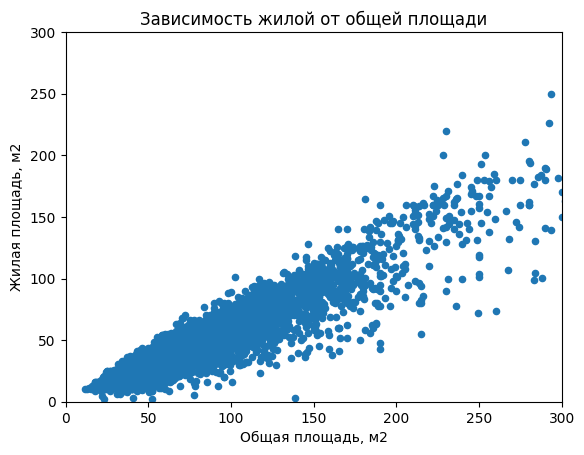

In [9]:
df.plot(x='total_area', y='living_area', kind='scatter', xlim=(0, 300), ylim=(0, 300));

plt.xlabel('Общая площадь, м2')
plt.ylabel('Жилая площадь, м2')
plt.title('Зависимость жилой от общей площади')
plt.show;

Предварительно проведем проверку на аномальное соотношение площадей -- общая площадь не должна быть меньше или равной сумме жилой площади и площади кухни (с некоторым допуском, учитывающим оставшиеся помещения квартиры):

In [10]:
df.query('total_area*0.9 <= (living_area + kitchen_area) and kitchen_area.isna() != True and living_area.isna() != True').shape[0]

475

В исходном массиве существуют данные, у которых нет соответствия между площадями составляющих квартиры

In [11]:
df.living_area = df.living_area.fillna(df['total_area'] * 0.5635 + 3.1809)
df.query('total_area*0.9 <= (living_area + kitchen_area) and kitchen_area.isna() != True').shape[0]

588

Алгоритм привел к увеличению аномальных записей в сравнении с изначальным массивом. Вернем пустые значения обратно:

In [12]:
# заново записываем фрейм
df = pd.read_csv('/Users/ilatti/Documents/practicum/3_third_sprint/project/real_estate_data.csv', sep="\t")

Рассмотрим уникальные значения столбца `is_apartment`

In [13]:
df['is_apartment'].sort_values().unique()

array([False, True, nan], dtype=object)

Одним из возможных решений было бы заменить все пропуски на `False`, но смущает то, что пропуски у ~ 90 % записей, посмотрим несколько таких записей:

In [14]:
df[df['is_apartment'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00


Объекты подходят под описание "является квартирой" судя по наличию нескольких этажей и площади объектов

Рассмотрим объявления, для которых показатель равен 0 и 1:

In [15]:
df[df['is_apartment'] == False].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
11,9,"3,300,000.00",44.00,2018-08-27T00:00:00,2,NaN,5.00,31.00,4,False,...,6.00,1.00,Ломоносов,"48,252.00","51,677.00",0.00,NaN,0.00,NaN,7.00
25,3,"6,800,000.00",76.00,2015-10-01T00:00:00,2,2.75,23.00,39.00,18,False,...,15.00,2.00,Санкт-Петербург,"34,967.00","14,640.00",0.00,NaN,1.00,564.00,300.00
29,9,"8,600,000.00",100.00,2016-04-09T00:00:00,3,NaN,19.00,52.00,15,False,...,11.00,0.00,Санкт-Петербург,"30,394.00","11,526.00",1.00,532.00,1.00,896.00,125.00
36,13,"3,790,000.00",45.00,2017-01-25T00:00:00,2,NaN,9.00,27.00,9,False,...,6.30,2.00,Санкт-Петербург,"49,574.00","16,461.00",1.00,459.00,0.00,NaN,139.00
41,16,"7,900,000.00",74.00,2016-05-04T00:00:00,3,NaN,14.00,59.00,8,False,...,12.00,5.00,Санкт-Петербург,"37,715.00","12,612.00",1.00,725.00,1.00,759.00,179.00


In [16]:
df[df['is_apartment'] == True].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
543,11,"12,790,000.00",56.60,2018-11-06T00:00:00,2,3.50,3.00,29.40,1,True,...,NaN,NaN,Петергоф,"35,248.00","30,437.00",3.00,53.00,3.00,22.00,NaN
916,11,"8,183,000.00",70.00,2018-01-11T00:00:00,2,3.12,3.00,40.00,3,True,...,NaN,2.00,Санкт-Петербург,"45,796.00","21,729.00",0.00,NaN,1.00,754.00,179.00
1109,1,"34,878,556.00",95.80,2014-12-09T00:00:00,2,NaN,6.00,58.30,5,True,...,20.00,1.00,Санкт-Петербург,"21,860.00",318.00,2.00,160.00,3.00,569.00,"1,572.00"
1608,12,"2,150,000.00",20.10,2019-01-30T00:00:00,1,NaN,9.00,NaN,1,True,...,NaN,NaN,Санкт-Петербург,"26,646.00","12,147.00",0.00,NaN,0.00,NaN,13.00
2759,11,"7,500,000.00",152.00,2018-07-27T00:00:00,3,3.00,3.00,NaN,1,True,...,NaN,1.00,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,7.00


Никакой связи между общим числом этажей, количеством комнат и показателем `is_apartment` не замечено

Оставим пропуски как есть. 

Необходимо уточнить, что это за показатель и каким образом он заполняется. Может быть проблема в форме на сайте?

В столбце `balcony` пропуски заменим на значение 0; маловероятно, что в объявлении не было бы указано количество балконов, если они есть:

In [17]:
df['balcony'] = df['balcony'].fillna(0)
df['balcony'].unique()

array([0., 2., 1., 5., 4., 3.])

Пропуски `days_exposition` оставим как есть, это явно соответствует квартирам, которые еще не проданы.

Высоту потолков на основе предоставленных данных вычислить не удастся -- низкие значения коэффициента корреляции с любым известным показателем, оставим пропуски.

Картографические данные, вероятно, имеют пропуски из-за отсутствия координат некоторых домов. Оставляем пропуски, заполнить их на основании предоставленных данных не представляется возможным.

Пропуски в `floors_total` удалим, их минимальное количество; удаление позволит в будущем преобразовать тип данных в целочисленный

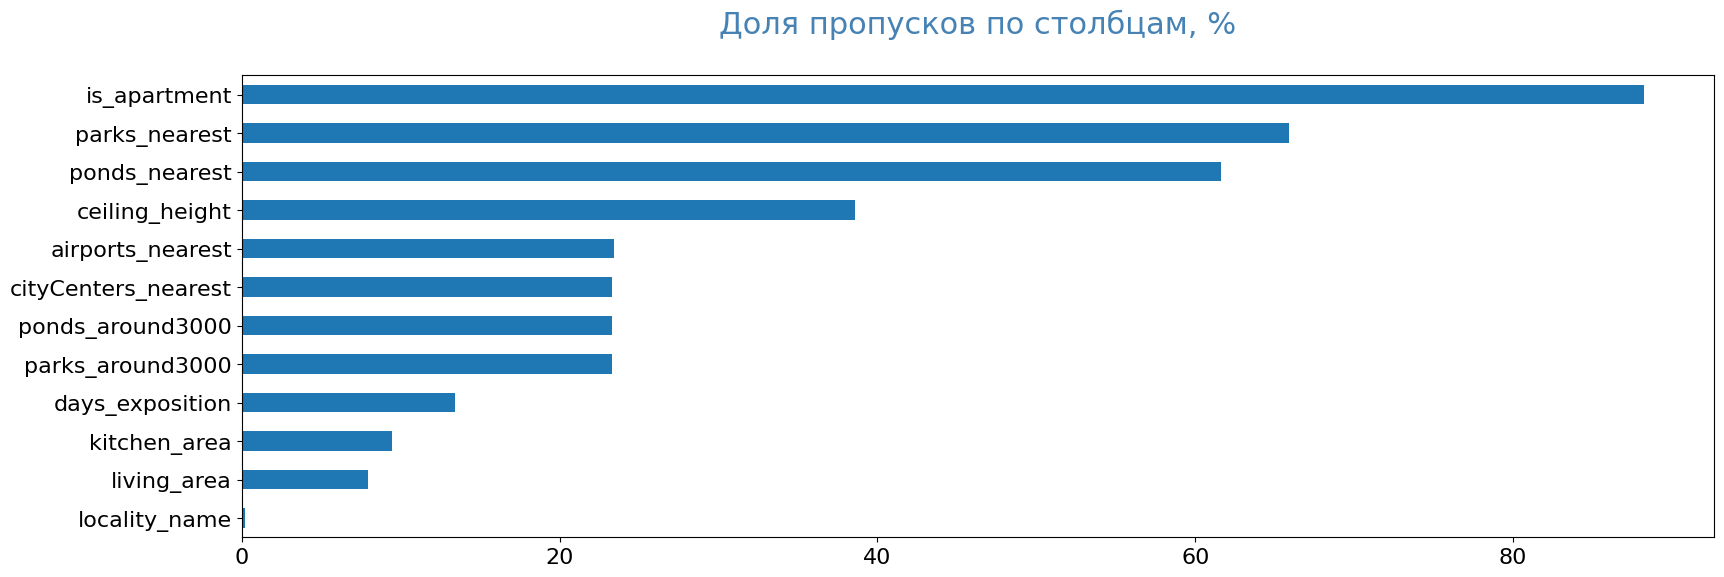

In [18]:
df = df.dropna(subset=['floors_total'])
pass_value_barh(df)

**Вывод:** 
На текущем этапе пропуски в показателе количества балконов заполнены нулями. 

Пропуски в общем количестве этажей удалены.

Оставшиеся показатели без изменений: введенные пользователями параметры не показали адекватной корреляции друг с другом для заполнения на их основе, а картографические показатели заполнить не представляется возможным.

### Типы данных

Выведем используемые типы данных:

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        14495 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21743 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          21382 non-null  float64
 13  balcony               23613 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

Для столбцов 

`last_price` `floors_total` `balcony` `airports_nearest` `cityCenters_nearest` `parks_around3000` `parks_nearest` `ponds_around3000` `ponds_nearest` `days_exposition` 

использование вещественного типа данных избыточно, изменим тип данных на целочисленный для столбцов без пропущенных значений (`NaN` имеет вещественный тип, столбцы с пропусками преобразовать к целочисленному типу не удастся), это позволит использовать меньше памяти при работе с данными, а также ускорит работу с ними: 

In [20]:
float_to_int = ['last_price', 'balcony', 'floors_total'] # список столбцов, где нет пропусков и целесообразно изменить тип на 'int'

for i in float_to_int:
    df[i] = df[i].astype('int')

Приведем столбец `first_day_exposition` к типу даты:

In [21]:
display(df.head())
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y%m%dT%H:%M:%S')
display(df.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.00,2019-03-07T00:00:00,3,2.70,16,51.00,8,NaN,...,25.00,0,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,3350000,40.40,2018-12-04T00:00:00,1,NaN,11,18.60,1,NaN,...,11.00,2,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,5196000,56.00,2015-08-20T00:00:00,2,NaN,5,34.30,4,NaN,...,8.30,0,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,64900000,159.00,2015-07-24T00:00:00,3,NaN,14,NaN,9,NaN,...,NaN,0,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,10000000,100.00,2018-06-19T00:00:00,2,3.03,14,32.00,13,NaN,...,41.00,0,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.00,8,NaN,...,25.00,0,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,3350000,40.40,2018-12-04,1,NaN,11,18.60,1,NaN,...,11.00,2,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,5196000,56.00,2015-08-20,2,NaN,5,34.30,4,NaN,...,8.30,0,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,64900000,159.00,2015-07-24,3,NaN,14,NaN,9,NaN,...,NaN,0,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.00,13,NaN,...,41.00,0,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  int64         
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        14495 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           21743 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21382 non-null  float64       
 13  balcony         

Преобразование даты успешно

**Вывод:** 
Тип данных в столбцах `floors_total` `last_price` и `balcony` изменены с `float` на `int`. 

В столбце `first_day_exposition` c `object` на `datetime`. 

Эти изменения позволят более рационально использовать ресурсы оперативной памяти и ускорит работу с данными, в случае с датой это также значительно увеличит удобство работы.

### Дубликаты

Проверим наличие полных дубликатов в данных:

In [23]:
df.duplicated().sum()

0

Явных дубликатов не обнаружено

Выведем список уникальных названий в `locality_name` и найдем в нем неявные дубликаты:

In [24]:
df['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [25]:
df.locality_name.nunique()

364

Переформатируем названия однообразно:

In [26]:
df.locality_name.nunique()



df['locality_name'] = df['locality_name'].str.replace('посёлок', 'поселок')

change_list = [
              ['городской поселок', 'поселок'],
              ['коттеджный поселок', 'поселок'],
              ['поселок городского типа', 'поселок'],
              ['поселок станции', 'поселок'],
              ['поселок при железнодорожной станции', 'поселок'],
              ['садоводческое некоммерческое товарищество', 'садовое товарищество'],
              ['поселок имени', 'поселок'],
              ]

for i in range(len(change_list)):
    df['locality_name'] = df['locality_name'].str.replace(change_list[i][0], change_list[i][1])
    
df['locality_name'].sort_values().unique()


array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'деревня Агалатово', 'деревня Аро', 'деревня Батово',
       'деревня Бегуницы', 'деревня Белогорка', 'деревня Большая Вруда',
       'деревня Большая Пустомержа', 'деревня Большие Колпаны',
       'деревня Большое Рейзино', 'деревня Большой Сабск', 'деревня Бор',
       'деревня Борисова Грива', 'деревня Ваганово', 'деревня Вартемяги',
       'деревня Вахнова Кара', 'деревня Выскатка

In [27]:
df.locality_name.nunique()

318

**Вывод:** 
На текущем этапе ликвидировали неявные дубликаты названий населенных пунктов (например `посёлок` - `поселок`, `поселок городского типа` - `поселок`) 

### Аномальные значения

На данном этапе выявим и исправим аномальные значения в столбцах. Начнем с высоты потолков:

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

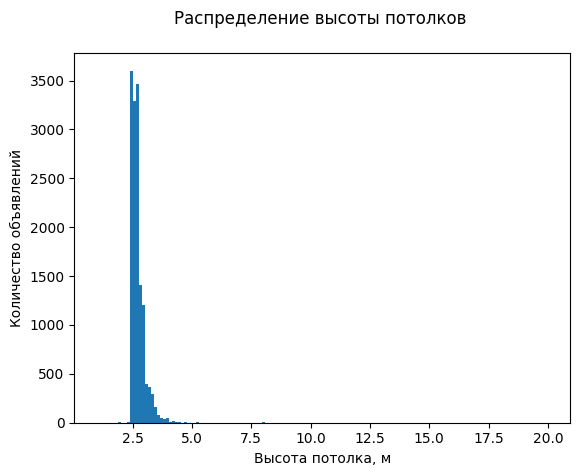

In [28]:
df['ceiling_height'].hist(bins=150, range=(1, 20), grid=False)
plt.title('Распределение высоты потолков \n')
plt.xlabel('Высота потолка, м')
plt.ylabel('Количество объявлений')
df['ceiling_height'].sort_values().unique()

Видим, что в данных есть аномально низкие и аномально высокие значения. Примем, что ниже `2.2 метров` -- это слишком низкий потолок, а выше `3.8 метров` -- слишком высокий. Какой процент от всех данных составляют такие данные?

In [29]:
frac_ceil = df.query('ceiling_height > 3.8 or ceiling_height < 2.2').shape[0] / df.shape[0]
print(f'Доля аномально высоких/низких потолков {frac_ceil:.2%}')

Доля аномально высоких/низких потолков 0.68%


Значения высоты не менее 22 м, но не более 32 м разделим на 10, скорее всего, это некорректно записанные значения:

In [30]:
df['ceiling_height'] = (df['ceiling_height']
                        .where((df['ceiling_height'] > 32) | (df['ceiling_height'] < 22), 
                               df['ceiling_height'] / 10)
                       )

In [31]:
df['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.26,   2.3 ,
         2.34,   2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,
         2.51,   2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,
         2.59,   2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,
         2.67,   2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,
         2.75,   2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,
         2.83,   2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,
         2.91,   2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,
         2.99,   3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,
         3.07,   3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,
         3.15,   3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,
         3.24,   3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,
         3.32,   3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,
         3.4 ,   3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,
      

Оставшиеся аномальные значения, выходящие за пределы интервала `[2.2; 3.8]`, удалим из массива данных:

array([2.2 , 2.25, 2.26, 2.3 , 2.34, 2.4 , 2.45, 2.46, 2.47, 2.48, 2.49,
       2.5 , 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6 ,
       2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.71,
       2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82,
       2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9 , 2.91, 2.92, 2.93,
       2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.  , 3.01, 3.02, 3.03, 3.04,
       3.05, 3.06, 3.07, 3.08, 3.09, 3.1 , 3.11, 3.12, 3.13, 3.14, 3.15,
       3.16, 3.17, 3.18, 3.2 , 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27,
       3.28, 3.29, 3.3 , 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38,
       3.39, 3.4 , 3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5 ,
       3.51, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.6 , 3.62,
       3.63, 3.65, 3.66, 3.67, 3.68, 3.69, 3.7 , 3.75, 3.76, 3.78, 3.8 ,
        nan])

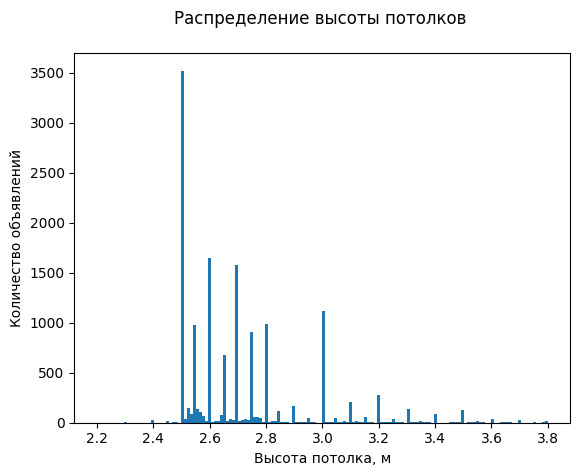

In [32]:
df = df.drop(df.query('ceiling_height > 3.8 or ceiling_height < 2.2').index)
df['ceiling_height'].hist(bins=150, grid=False)
plt.title('Распределение высоты потолков \n')
plt.xlabel('Высота потолка, м')
plt.ylabel('Количество объявлений')

df['ceiling_height'].sort_values().unique()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23473 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23473 non-null  int64         
 1   last_price            23473 non-null  int64         
 2   total_area            23473 non-null  float64       
 3   first_day_exposition  23473 non-null  datetime64[ns]
 4   rooms                 23473 non-null  int64         
 5   ceiling_height        14355 non-null  float64       
 6   floors_total          23473 non-null  int64         
 7   living_area           21613 non-null  float64       
 8   floor                 23473 non-null  int64         
 9   is_apartment          2752 non-null   object        
 10  studio                23473 non-null  bool          
 11  open_plan             23473 non-null  bool          
 12  kitchen_area          21256 non-null  float64       
 13  balcony         

Лишние данные не потеряны, с параметром высоты потолков разобрались

Построим гистограммы всех показателей, чтобы выявить другие аномалии:

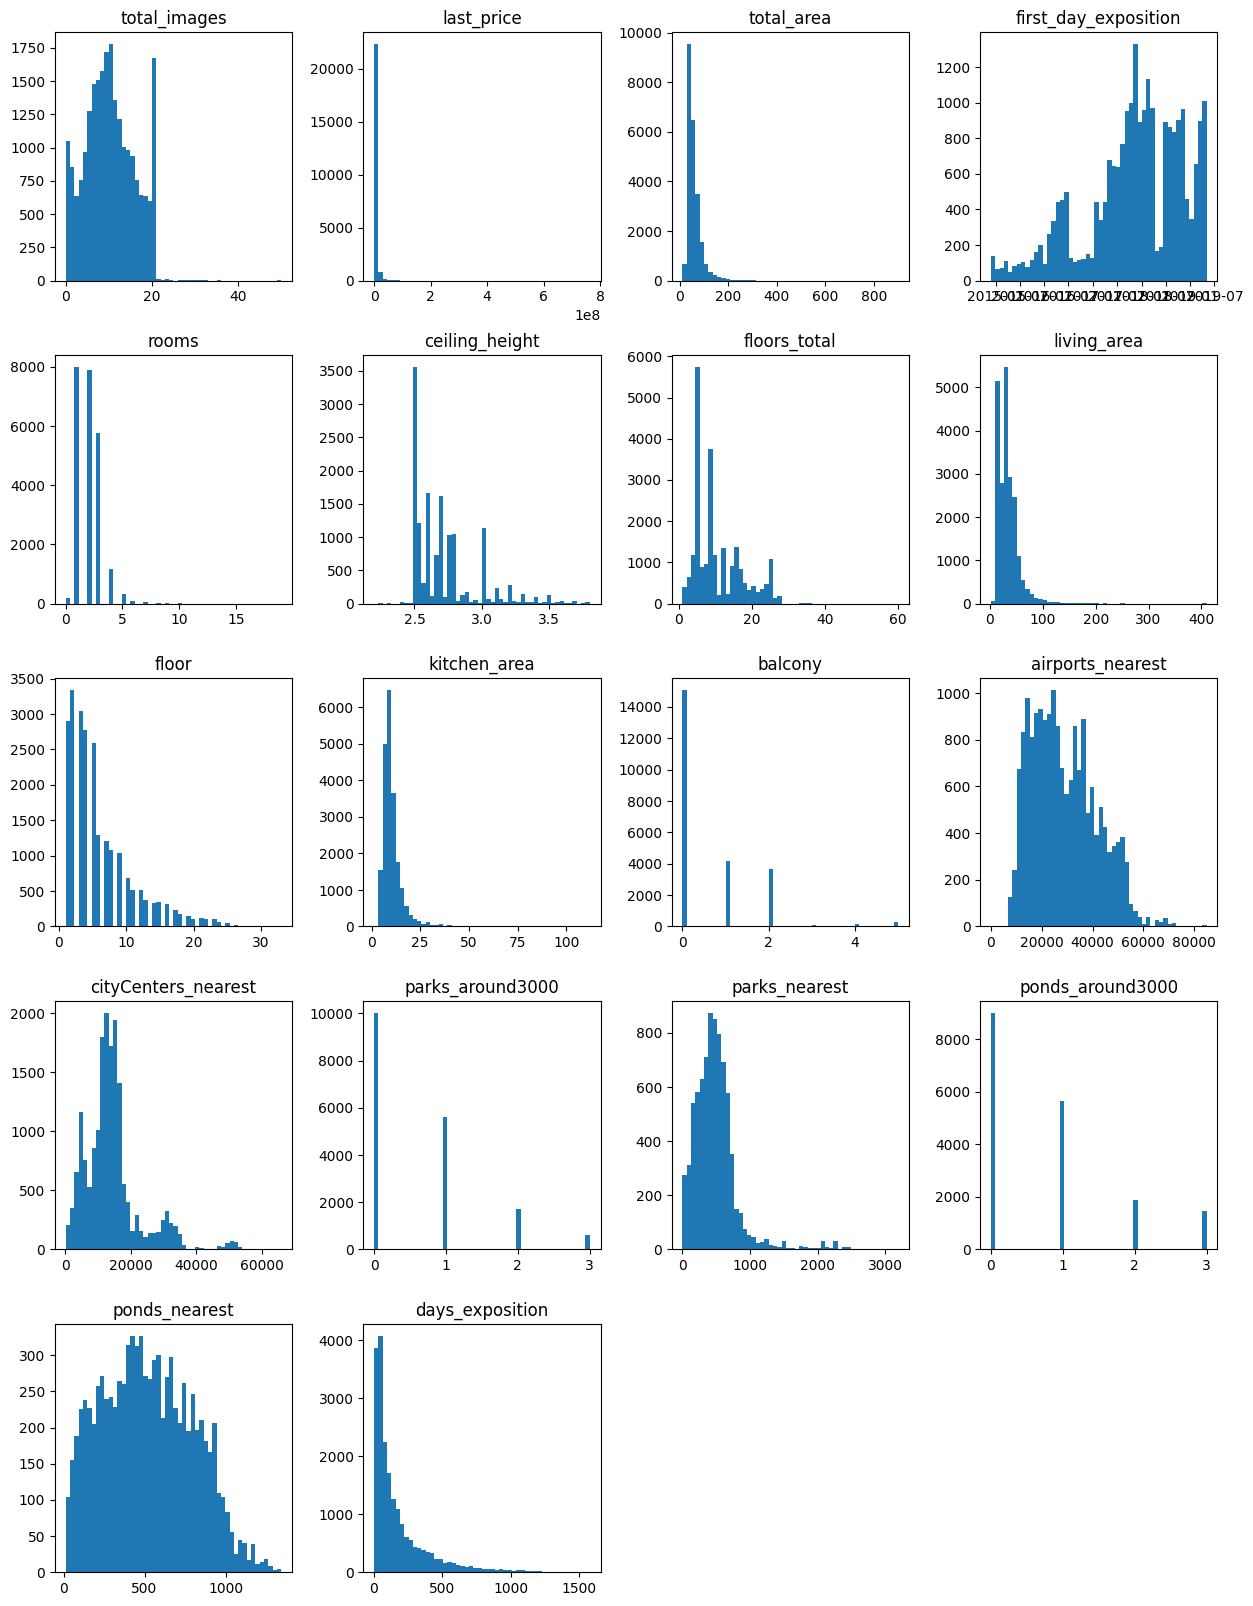

In [34]:
df.hist(figsize=(15, 20), bins=50, grid=False);

На гистограммах видны аномально низкие значения площади у некоторых объектов, посмотрим подробнее:

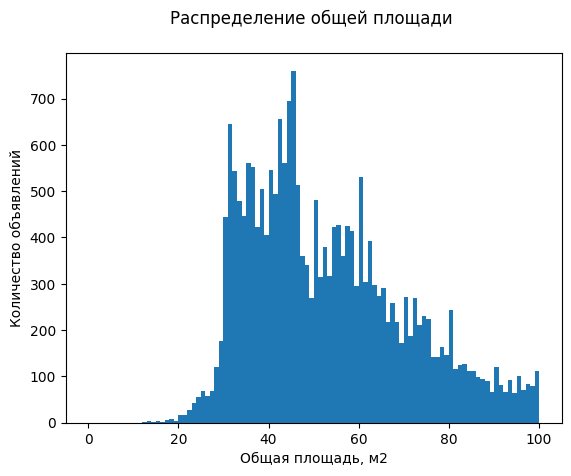

In [35]:
df['total_area'].hist(bins=100, range=(0, 100), grid=False);
plt.title('Распределение общей площади \n')
plt.xlabel('Общая площадь, м2')
plt.ylabel('Количество объявлений');

Отсортируем таблицу по значению площади и посмотрим на первые записи:

In [36]:
df.sort_values(by='total_area').head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19904,4,2400000,12.00,2017-07-19,1,2.55,5,10.00,2,NaN,...,NaN,0,Санкт-Петербург,"21,314.00",964.00,1.00,886.00,2.00,45.00,200.00
19807,0,3800000,13.00,2018-07-04,1,NaN,5,10.00,3,NaN,...,NaN,0,Санкт-Петербург,"21,302.00","1,242.00",1.00,592.00,3.00,27.00,9.00
19546,3,1850000,13.00,2019-03-11,1,3.40,5,NaN,2,False,...,NaN,0,Санкт-Петербург,"24,915.00","5,483.00",1.00,644.00,0.00,NaN,24.00
17961,3,1400000,13.00,2017-12-03,1,2.60,9,NaN,1,NaN,...,NaN,0,Санкт-Петербург,"14,350.00","15,945.00",0.00,NaN,1.00,185.00,410.00
19558,2,1686000,13.20,2018-12-17,1,NaN,5,NaN,1,NaN,...,NaN,0,Санкт-Петербург,"19,891.00","4,165.00",1.00,361.00,1.00,155.00,19.00
19642,5,1190000,14.00,2018-07-29,1,NaN,5,11.00,1,NaN,...,2.00,0,Санкт-Петербург,"9,898.00","11,122.00",0.00,NaN,0.00,NaN,4.00
12040,5,1900000,15.00,2018-06-27,1,2.50,5,NaN,1,NaN,...,NaN,0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.00
16949,9,1550000,15.00,2018-08-21,1,2.70,9,NaN,1,NaN,...,NaN,0,Санкт-Петербург,"51,048.00","16,376.00",0.00,NaN,1.00,"1,079.00",42.00
8886,10,2450000,15.50,2018-08-22,0,NaN,5,10.00,2,NaN,...,NaN,0,Санкт-Петербург,"24,326.00","4,589.00",0.00,NaN,1.00,446.00,27.00
9412,5,2100000,16.00,2017-12-10,0,NaN,6,13.00,1,NaN,...,NaN,0,Санкт-Петербург,"20,735.00","2,111.00",2.00,228.00,3.00,72.00,3.00


Судя по всему, это действительно маленькие квартиры, но смущает, что в очевидных студиях количество комнат бывает как `1`, так и `0`. Запишем везде `1`:

In [37]:
df['rooms'] = df['rooms'].where(df['rooms'] != 0, 1)
df.sort_values(by='total_area').head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19904,4,2400000,12.00,2017-07-19,1,2.55,5,10.00,2,NaN,...,NaN,0,Санкт-Петербург,"21,314.00",964.00,1.00,886.00,2.00,45.00,200.00
19807,0,3800000,13.00,2018-07-04,1,NaN,5,10.00,3,NaN,...,NaN,0,Санкт-Петербург,"21,302.00","1,242.00",1.00,592.00,3.00,27.00,9.00
19546,3,1850000,13.00,2019-03-11,1,3.40,5,NaN,2,False,...,NaN,0,Санкт-Петербург,"24,915.00","5,483.00",1.00,644.00,0.00,NaN,24.00
17961,3,1400000,13.00,2017-12-03,1,2.60,9,NaN,1,NaN,...,NaN,0,Санкт-Петербург,"14,350.00","15,945.00",0.00,NaN,1.00,185.00,410.00
19558,2,1686000,13.20,2018-12-17,1,NaN,5,NaN,1,NaN,...,NaN,0,Санкт-Петербург,"19,891.00","4,165.00",1.00,361.00,1.00,155.00,19.00
19642,5,1190000,14.00,2018-07-29,1,NaN,5,11.00,1,NaN,...,2.00,0,Санкт-Петербург,"9,898.00","11,122.00",0.00,NaN,0.00,NaN,4.00
12040,5,1900000,15.00,2018-06-27,1,2.50,5,NaN,1,NaN,...,NaN,0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.00
16949,9,1550000,15.00,2018-08-21,1,2.70,9,NaN,1,NaN,...,NaN,0,Санкт-Петербург,"51,048.00","16,376.00",0.00,NaN,1.00,"1,079.00",42.00
8886,10,2450000,15.50,2018-08-22,1,NaN,5,10.00,2,NaN,...,NaN,0,Санкт-Петербург,"24,326.00","4,589.00",0.00,NaN,1.00,446.00,27.00
9412,5,2100000,16.00,2017-12-10,1,NaN,6,13.00,1,NaN,...,NaN,0,Санкт-Петербург,"20,735.00","2,111.00",2.00,228.00,3.00,72.00,3.00


Проверим, встречаются ли значения жилой площади больше или равные общей площади:

In [38]:
df.query('living_area >= total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
9861,10,2350000,25.00,2017-12-03,1,NaN,22,25.00,17,NaN,...,NaN,2,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,13.00
12691,1,3700000,24.20,2017-11-10,1,NaN,19,24.20,13,NaN,...,NaN,1,Санкт-Петербург,"17,837.00","16,840.00",0.00,NaN,2.00,210.00,74.00


Значения встречаются, их количество невелико, удалим их:

In [39]:
df = df.query('living_area < total_area or living_area.isna()')
df.query('living_area >= total_area') # проверка на успешность удаления

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Проверим соотношение площади кухни и общей площади:

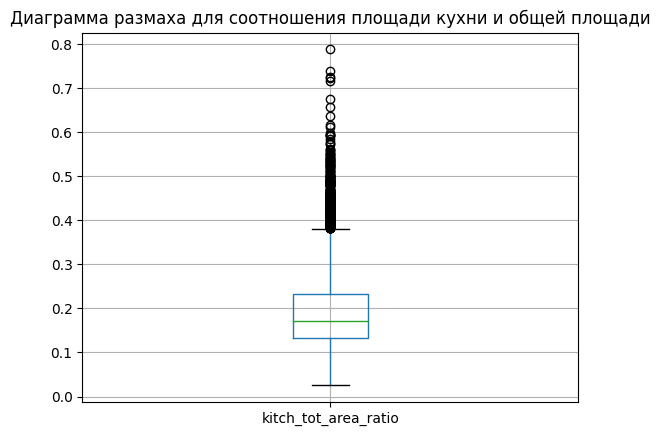

In [40]:
df['kitch_tot_area_ratio'] = df['kitchen_area']/ df['total_area']
df.boxplot(column='kitch_tot_area_ratio')
plt.title('Диаграмма размаха для соотношения площади кухни и общей площади');

Кухня, составляющая 50 или даже 40 % от квартиры -- это некорректные данные, проверим, сколько таких записей:

In [41]:
df.query('kitch_tot_area_ratio > 0.36').shape[0]

489

Данных немного, но они могут повлияет на дальнейший анализ, удалим их:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22982 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22982 non-null  int64         
 1   last_price            22982 non-null  int64         
 2   total_area            22982 non-null  float64       
 3   first_day_exposition  22982 non-null  datetime64[ns]
 4   rooms                 22982 non-null  int64         
 5   ceiling_height        14076 non-null  float64       
 6   floors_total          22982 non-null  int64         
 7   living_area           21144 non-null  float64       
 8   floor                 22982 non-null  int64         
 9   is_apartment          2703 non-null   object        
 10  studio                22982 non-null  bool          
 11  open_plan             22982 non-null  bool          
 12  kitchen_area          20767 non-null  float64       
 13  balcony         

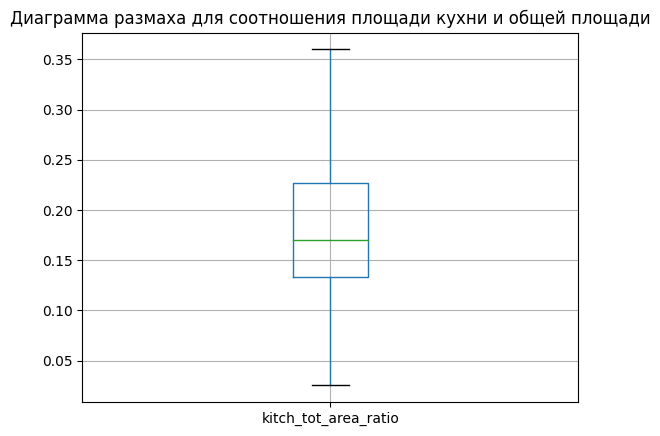

In [42]:
df = df.query('kitch_tot_area_ratio <= 0.36 or kitchen_area.isna()')
df.boxplot(column='kitch_tot_area_ratio')
plt.title('Диаграмма размаха для соотношения площади кухни и общей площади')
df.info()

Оценим оставшиеся данные:

In [43]:
(
    df[['rooms', 'total_area', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floors_total']]
    .apply (['count', 'min', 'max', 'median'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,days_exposition,last_price,living_area,kitchen_area,floors_total
count,"22,982.00","22,982.00","19,913.00","22,982.00","21,144.00","20,767.00","22,982.00"
min,1.00,12.00,1.00,"430,000.00",2.00,1.30,1.00
max,19.00,900.00,"1,580.00","763,000,000.00",409.70,112.00,60.00
median,2.00,52.00,95.00,"4,600,000.00",30.00,9.00,9.00


Посчитаем квантили для выбивающихся значений

In [44]:
q_min1 = 0.01
q_min2 = 0.0012

q_max1 = .99
q_max2 = .9988

target_columns = ['rooms', 'total_area', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floors_total']

In [45]:
df_anomaly_stat = (
    df[target_columns]
    .quantile([q_min2, q_min1, q_max1, q_max2]) # выбираем размах в 0,9976 квантилей 
)
df_anomaly_stat

,rooms,total_area,days_exposition,last_price,living_area,kitchen_area,floors_total
0.00,1.00,20.00,3.00,"573,658.00",10.00,3.79,2.00
0.01,1.00,25.32,4.00,"1,000,000.00",14.00,5.00,2.00
0.99,5.00,190.00,"1,068.76","33,557,000.00",114.40,30.00,26.00
1.00,8.00,367.54,"1,373.21","98,422,800.00",198.63,48.56,33.42


Исключим из выборки самые редкие значения:

In [46]:
for i in target_columns:
    max_border = df_anomaly_stat.loc[q_max2, i]
    min_border = df_anomaly_stat.loc[q_min2, i]
    
    df = df.loc[ ((df.loc[:, i] <= max_border) & (df.loc[:, i] >= min_border)) | (df.loc[:, i].isna()) ] # забираем данные в установленных границах, либо пустые
print(f'Потери данных составляют {1 - df.shape[0]/23699:.0%}')

Потери данных составляют 4%


In [47]:
(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max', 'median'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,743.00","22,743.00","13,947.00","19,707.00","22,743.00","20,939.00","20,584.00","22,743.00","22,743.00"
min,1.00,20.00,2.20,3.00,"580,000.00",10.00,3.80,1.00,2.00
max,8.00,365.00,3.80,"1,373.00","98,000,000.00",194.00,48.50,32.00,33.00
median,2.00,52.00,2.65,95.00,"4,600,000.00",30.00,9.00,4.00,9.00


### **Вывод** 
В ходе проведенной предобработки данных выявлены пропуски значений, некорректные типы данных, неявные дубликаты в названиях и аномальные значения в столбцах.

- Пропуски в данных заполнили следующим образом:  
    - В показателе количества балконов пропуски заполнены нулями; 
    - Пропуски в общем количестве этажей удалены;
    - Оставшиеся показатели без изменений: введенные пользователями параметры не показали адекватной корреляции друг с другом для заполнения на их основе, а картографические показатели заполнить не представляется возможным.


- Тип данных в столбцах `floors_total` `last_price` и `balcony` изменены с `float` на `int`. В столбце `first_day_exposition` c `object` на `datetime`;
    - Эти изменения позволят более рационально использовать ресурсы оперативной памяти и ускорит работу с данными, в случае с датой это также значительно увеличит удобство работы.


- Ликвидировали неявные дубликаты названий населенных пунктов (например 'посёлок' - 'поселок') путем замены на одно общее название.


- Аномальные значения выявлены в столбцах `ceiling_height`, `living_area`, `kitchen_area`, `rooms`, `total_area`, `days_exposition`, `last_price`, `floors_total`. 
    - Высота потолков в диапазоне `22 - 38` метров уменьшена в `10` раз, оставшиеся строки со значениями за пределами `2.2 - 3.8` метров удалены как некорректные;
    - Удалены строки со значениями жилой площади, превышающей общую; 
    - Данные очищены от значений за пределами `0,9976` квантилей, как малочисленные и выбивающиеся из общей выборки. 

Изначальный массив данных составлял `23699` строк, после предобработки составил `22743` строк. Удалено ~ `4 %` данных. Внесенные изменения улучшили качество данных, на их основании удастся сделать более уверенные выводы.

## Расчет вспомогательных величин

In [48]:
df['sq_meter_price'] = df['last_price'] / df['total_area'] # расчет стоимости одного кв. метра [руб/м2]
df['weekday_exposition'] = df['first_day_exposition'].dt.weekday # день недели публикации
df['month_exposition'] = df['first_day_exposition'].dt.month # месяц публикации
df['year_exposition'] = df['first_day_exposition'].dt.year # год публикации
df['cityCenters_nearest_km'] = round(df['cityCenters_nearest'] / 1000) # расстояние до центра города в километрах

df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitch_tot_area_ratio,sq_meter_price,weekday_exposition,month_exposition,year_exposition,cityCenters_nearest_km
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.00,8,NaN,...,482.00,2.00,755.00,NaN,0.23,"120,370.37",3,3,2019,16.00
1,7,3350000,40.40,2018-12-04,1,NaN,11,18.60,1,NaN,...,NaN,0.00,NaN,81.00,0.27,"82,920.79",1,12,2018,19.00
2,10,5196000,56.00,2015-08-20,2,NaN,5,34.30,4,NaN,...,90.00,2.00,574.00,558.00,0.15,"92,785.71",3,8,2015,14.00
3,0,64900000,159.00,2015-07-24,3,NaN,14,NaN,9,NaN,...,84.00,3.00,234.00,424.00,NaN,"408,176.10",4,7,2015,7.00
5,10,2890000,30.40,2018-09-10,1,NaN,12,14.40,5,NaN,...,NaN,NaN,NaN,55.00,0.30,"95,065.79",0,9,2018,NaN


In [49]:
def floor_characteristic(data_frame): # функция для определения категории этажа объекта
    if data_frame['floor'] == 1:
        return('первый')
    elif data_frame['floors_total'] == data_frame['floor']:
        return('последний')
    elif data_frame['floor'] <= 0:
        return('ненатуральное число!')
    else: return('другой')    
    
df['floor_kind'] = df.apply(floor_characteristic, axis=1) # заполняем новый столбец выводом функции
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,kitch_tot_area_ratio,sq_meter_price,weekday_exposition,month_exposition,year_exposition,cityCenters_nearest_km,floor_kind
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.00,8,NaN,...,2.00,755.00,NaN,0.23,"120,370.37",3,3,2019,16.00,другой
1,7,3350000,40.40,2018-12-04,1,NaN,11,18.60,1,NaN,...,0.00,NaN,81.00,0.27,"82,920.79",1,12,2018,19.00,первый
2,10,5196000,56.00,2015-08-20,2,NaN,5,34.30,4,NaN,...,2.00,574.00,558.00,0.15,"92,785.71",3,8,2015,14.00,другой
3,0,64900000,159.00,2015-07-24,3,NaN,14,NaN,9,NaN,...,3.00,234.00,424.00,NaN,"408,176.10",4,7,2015,7.00,другой
5,10,2890000,30.40,2018-09-10,1,NaN,12,14.40,5,NaN,...,NaN,NaN,55.00,0.30,"95,065.79",0,9,2018,NaN,другой


## Исследовательский анализ данных

### Изучение параметров объектов

count   22,743.00
mean        59.13
std         29.86
min         20.00
25%         40.00
50%         52.00
75%         69.00
max        365.00
Name: total_area, dtype: float64

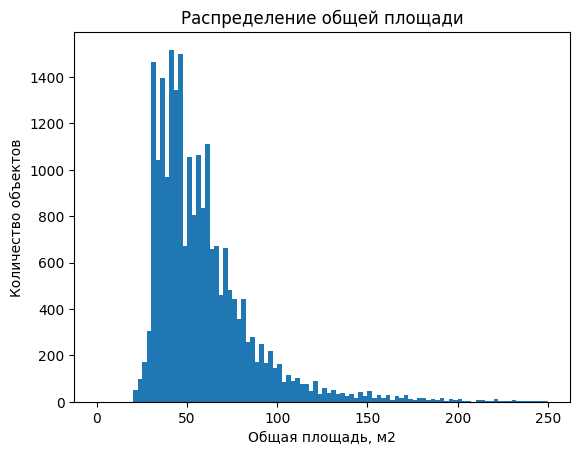

In [50]:
df['total_area'].plot(kind='hist', bins=100, range=(0, 250), title='Распределение общей площади')
plt.xlabel('Общая площадь, м2')
plt.ylabel('Количество объектов')
df['total_area'].describe()

count   20,939.00
mean        34.05
std         19.13
min         10.00
25%         18.87
50%         30.00
75%         42.30
max        194.00
Name: living_area, dtype: float64

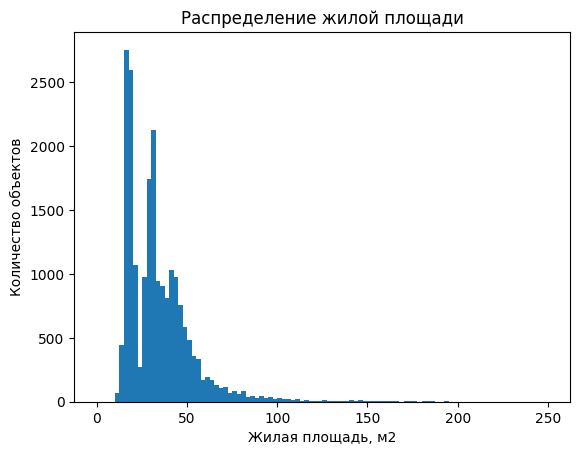

In [51]:
df['living_area'].plot(kind='hist', bins=100, range=(0, 250), title='Распределение жилой площади')
plt.xlabel('Жилая площадь, м2')
plt.ylabel('Количество объектов')
df['living_area'].describe()

count   20,584.00
mean        10.09
std          4.60
min          3.80
25%          7.00
50%          9.00
75%         11.50
max         48.50
Name: kitchen_area, dtype: float64

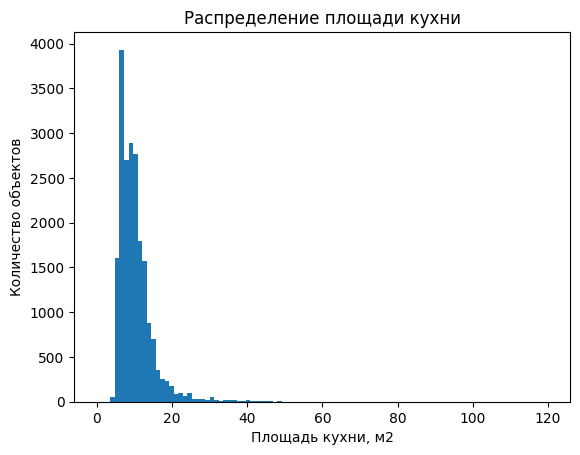

In [52]:
df['kitchen_area'].plot(kind='hist', bins=100, range=(0, 120), title='Распределение площади кухни')
plt.xlabel('Площадь кухни, м2')
plt.ylabel('Количество объектов')
df['kitchen_area'].describe()

count       22,743.00
mean     6,064,697.91
std      5,778,376.78
min        580,000.00
25%      3,400,000.00
50%      4,600,000.00
75%      6,690,000.00
max     98,000,000.00
Name: last_price, dtype: float64

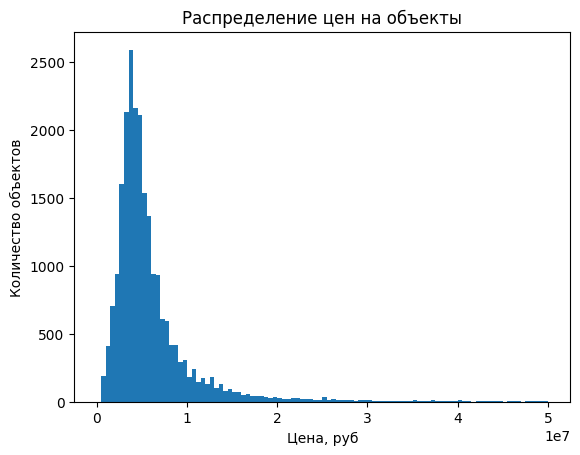

In [53]:
df['last_price'].plot(kind='hist', bins=100, range=(0, 50_000_000), title='Распределение цен на объекты')
plt.xlabel('Цена, руб')
plt.ylabel('Количество объектов')
df['last_price'].describe()

count   22,743.00
mean         2.07
std          1.01
min          1.00
25%          1.00
50%          2.00
75%          3.00
max          8.00
Name: rooms, dtype: float64

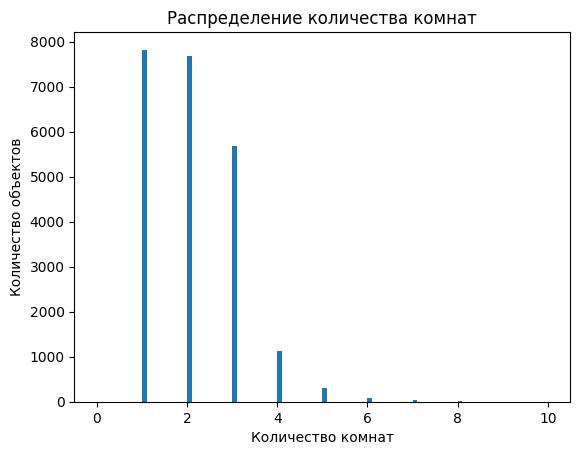

In [54]:
df['rooms'].plot(kind='hist', bins=100, range=(0, 10), title='Распределение количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество объектов')
df['rooms'].describe()

count   13,947.00
mean         2.71
std          0.24
min          2.20
25%          2.50
50%          2.65
75%          2.80
max          3.80
Name: ceiling_height, dtype: float64

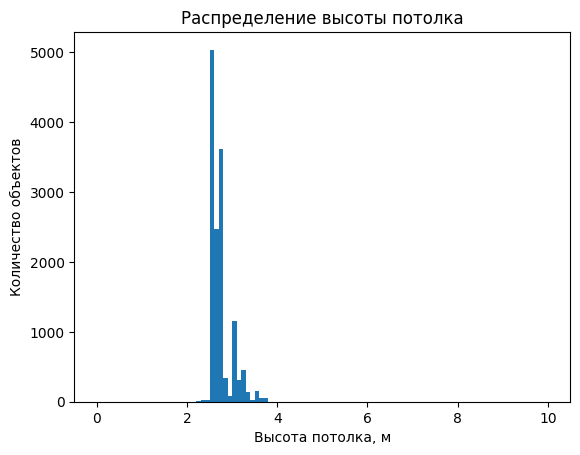

In [55]:
df['ceiling_height'].plot(kind='hist', bins=100, range=(0, 10), title='Распределение высоты потолка')
plt.xlabel('Высота потолка, м')
plt.ylabel('Количество объектов')
df['ceiling_height'].describe()

count   22,743.00
mean         5.85
std          4.83
min          1.00
25%          2.00
50%          4.00
75%          8.00
max         32.00
Name: floor, dtype: float64

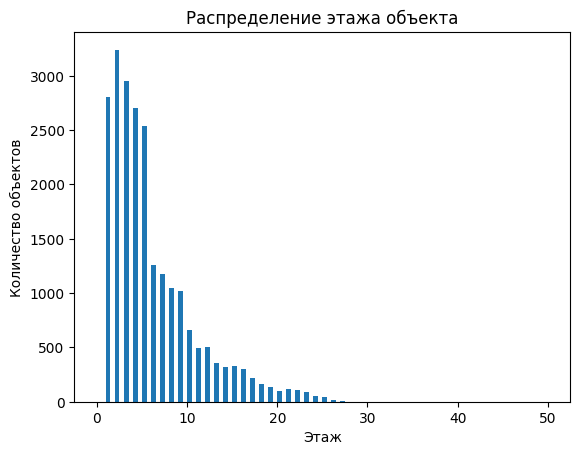

In [56]:
df['floor'].plot(kind='hist', bins=100, range=(0, 50), title='Распределение этажа объекта')
plt.xlabel('Этаж')
plt.ylabel('Количество объектов')
df['floor'].describe()

другой       16741
последний     3199
первый        2803
Name: floor_kind, dtype: int64

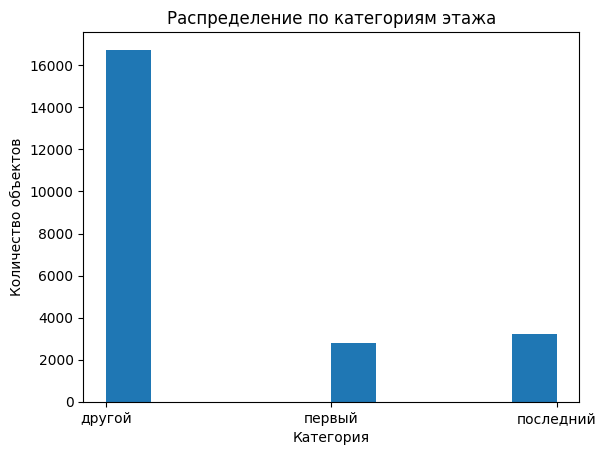

In [57]:
df['floor_kind'].hist()
plt.title('Распределение по категориям этажа')
plt.xlabel('Категория')
plt.ylabel('Количество объектов')
plt.grid(False)
df['floor_kind'].value_counts()

Из вероятностных соображений понятно, что большинство квартир не на первом и не на последнем этаже.

count   22,743.00
mean        10.65
std          6.51
min          2.00
25%          5.00
50%          9.00
75%         16.00
max         33.00
Name: floors_total, dtype: float64

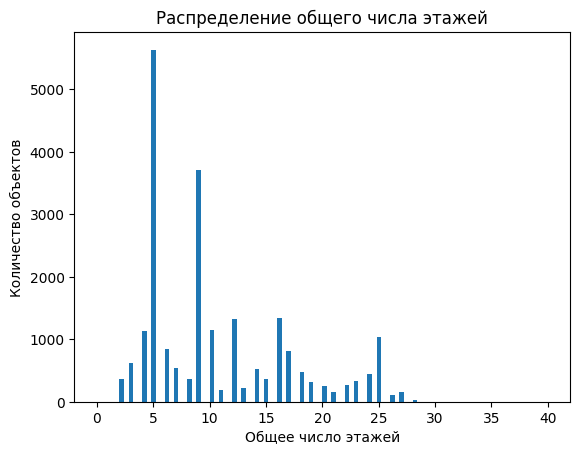

In [58]:
df['floors_total'].plot(kind='hist', bins=100, range=(0, 40), title='Распределение общего числа этажей')
plt.xlabel('Общее число этажей')
plt.ylabel('Количество объектов')
df['floors_total'].describe()

Видим, что абсолютно доминируют пятиэтажные и девятиэтажные здания.

count   17,421.00
mean    14,312.75
std      8,606.79
min        181.00
25%      9,488.00
50%     13,149.00
75%     16,300.00
max     65,968.00
Name: cityCenters_nearest, dtype: float64

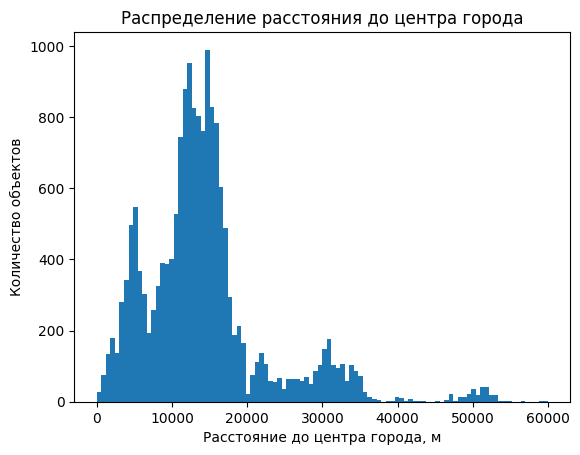

In [59]:
df['cityCenters_nearest'].plot(kind='hist', bins=100, range=(0, 60000), title='Распределение расстояния до центра города')
plt.xlabel('Расстояние до центра города, м')
plt.ylabel('Количество объектов')
df['cityCenters_nearest'].describe()

count   17,401.00
mean    28,819.71
std     12,683.08
min          0.00
25%     18,462.00
50%     26,832.00
75%     37,368.00
max     84,869.00
Name: airports_nearest, dtype: float64

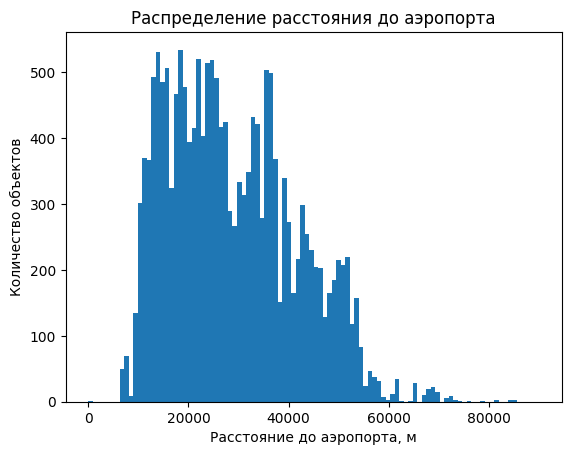

In [60]:
df['airports_nearest'].plot(kind='hist', bins=100, range=(0, 90000), title='Распределение расстояния до аэропорта')
plt.xlabel('Расстояние до аэропорта, м')
plt.ylabel('Количество объектов')
df['airports_nearest'].describe()

Большая часть объектов на расстоянии, не превышающем 37 км от аэропорта. Однако, есть объект на аномально маленьком расстоянии от аэропорта. Рассмотрим подробнее:

In [61]:
df[['airports_nearest', 'cityCenters_nearest', 'locality_name']].sort_values(by='airports_nearest').head()

,airports_nearest,cityCenters_nearest,locality_name
21085,0.00,"22,801.00",Санкт-Петербург
12899,"6,450.00","17,461.00",Санкт-Петербург
4017,"6,450.00","17,461.00",Санкт-Петербург
7778,"6,914.00","21,486.00",Санкт-Петербург
23150,"6,949.00","13,165.00",Санкт-Петербург


In [62]:
df.loc[[21085]]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,kitch_tot_area_ratio,sq_meter_price,weekday_exposition,month_exposition,year_exposition,cityCenters_nearest_km,floor_kind
21085,0,7000000,34.70,2018-09-23,1,2.70,9,19.80,3,NaN,...,0.00,NaN,60.00,0.17,"201,729.11",6,9,2018,23.00,другой


Судя по всему, ошибки нет: расстояние до центра города большое, видимо, эта квартира действительно находится в Пулково

count   7,686.00
mean      491.44
std       339.98
min         1.00
25%       288.00
50%       456.00
75%       613.00
max     3,190.00
Name: parks_nearest, dtype: float64

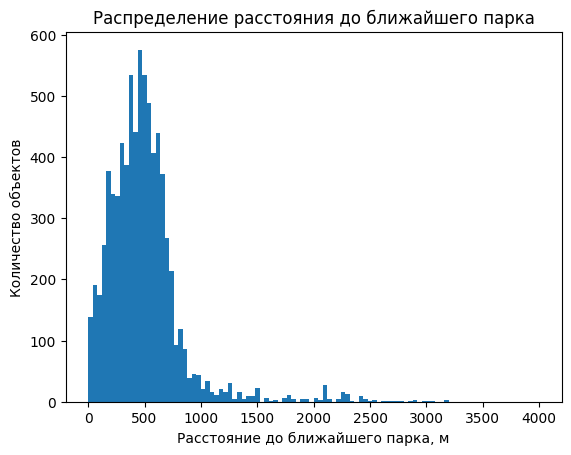

In [63]:
df['parks_nearest'].plot(kind='hist', bins=100, range=(0, 4000), title='Распределение расстояния до ближайшего парка')
plt.xlabel('Расстояние до ближайшего парка, м')
plt.ylabel('Количество объектов')
df['parks_nearest'].describe()

count   22,743.00
mean         2.57
std          1.79
min          0.00
25%          1.00
50%          3.00
75%          4.00
max          6.00
Name: weekday_exposition, dtype: float64

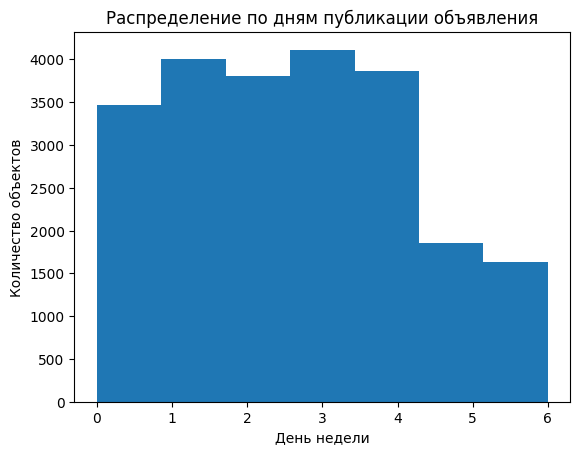

In [64]:
df['weekday_exposition'].plot(kind='hist', bins=7, range=(0, 6), title='Распределение по дням публикации объявления')
plt.xlabel('День недели')
plt.ylabel('Количество объектов')
df['weekday_exposition'].describe()

По будням объявления размещают гораздо чаще, чем по выходным.

count   22,743.00
mean         6.40
std          3.49
min          1.00
25%          3.00
50%          6.00
75%         10.00
max         12.00
Name: month_exposition, dtype: float64

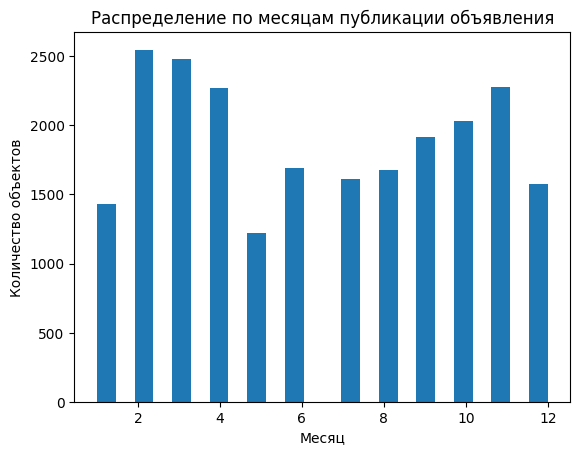

In [65]:
df['month_exposition'].plot(kind='hist', bins=24, range=(1, 12), title='Распределение по месяцам публикации объявления')
plt.xlabel('Месяц')
plt.ylabel('Количество объектов')
df['month_exposition'].describe()

Самый популярный месяц для размещения объявления -- февраль, за ним следует март, а после апрель. В мае виден резкий спад частоты публикаций, но впоследствии наблюдается плавный рост до ноября, достигая апрельских значений. Наконец, в декабре вновь виден резкий спад, продолжающийся и в январе.

#### **Вывод**
- В выборке, в основном, представлены обычные квартиры: пяти или девятиэтажные здания, от одной до трех комнат типичного размера;

- Чаще всего объявления размещают по будним дням, а самый популярный период года для размещения -- три месяца -- февраль, март, апрель.

### Анализ скорости продажи объектов

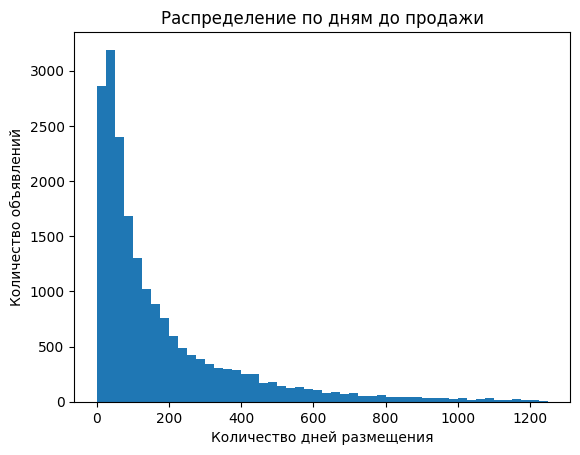

In [66]:
df['days_exposition'].plot(kind='hist', bins=50, range=(0, 1250), title='Распределение по дням до продажи');
plt.ylabel('Количество объявлений');
plt.xlabel('Количество дней размещения');

In [67]:
days_exp_mean = df['days_exposition'].mean()
days_exp_median = df['days_exposition'].median()

print(f'Среднее время продажи составляет {days_exp_mean:.0f} дней')
print(f'Медианное время продажи составляет {days_exp_median:.0f} дней')

Среднее время продажи составляет 179 дней
Медианное время продажи составляет 95 дней


Среднее смещено относительно медианы из-за наличия в выборке объектов с очень большим временем размещения

count   19,707.00
mean       178.58
std        214.56
min          3.00
25%         45.00
50%         95.00
75%        229.00
max      1,373.00
Name: days_exposition, dtype: float64

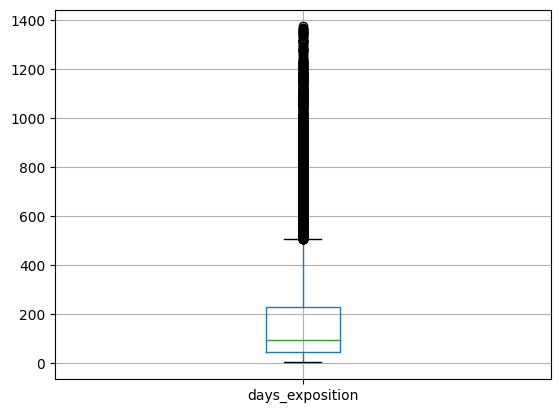

In [68]:
df.boxplot(column='days_exposition');
df['days_exposition'].describe()

#### **Вывод**
- Быстрыми продажами можно назвать те, у которых время продажи меньше или равно `45` дням, таких продаж только `25 %` (первый квартиль)

- Необычно долгое время достигается при превышении `229` дней, поскольку `75 %` продаж осуществляются быстрее (третий квартиль)

- Типичное время продажи характеризуется медианой: `95` дней

### Факторы влияния на стоимость объекта

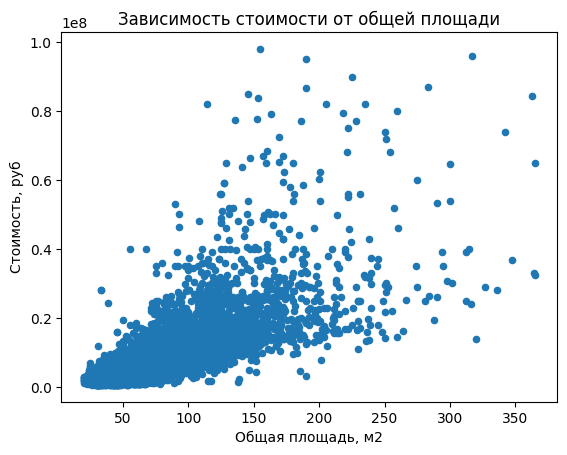

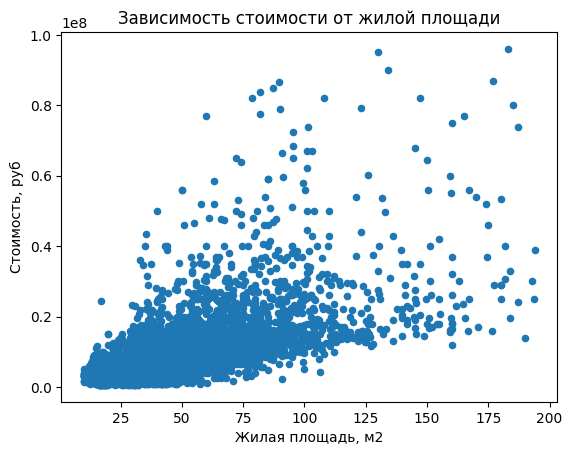

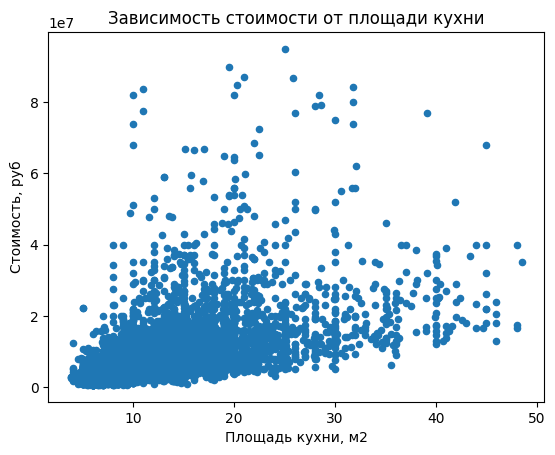

In [69]:
df.plot(x='total_area', y='last_price', kind='scatter')
plt.xlabel('Общая площадь, м2')
plt.ylabel('Стоимость, руб')
plt.title('Зависимость стоимости от общей площади')
plt.show

df.plot(x='living_area', y='last_price', kind='scatter')
plt.xlabel('Жилая площадь, м2')
plt.ylabel('Стоимость, руб')
plt.title('Зависимость стоимости от жилой площади')
plt.show

df.plot(x='kitchen_area', y='last_price', kind='scatter')
plt.xlabel('Площадь кухни, м2')
plt.ylabel('Стоимость, руб')
plt.title('Зависимость стоимости от площади кухни')
plt.show;

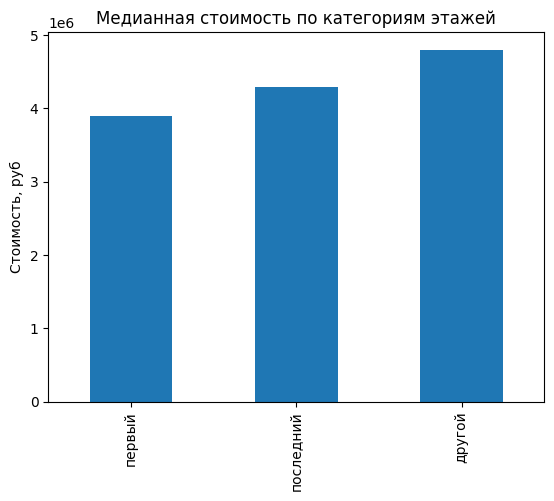

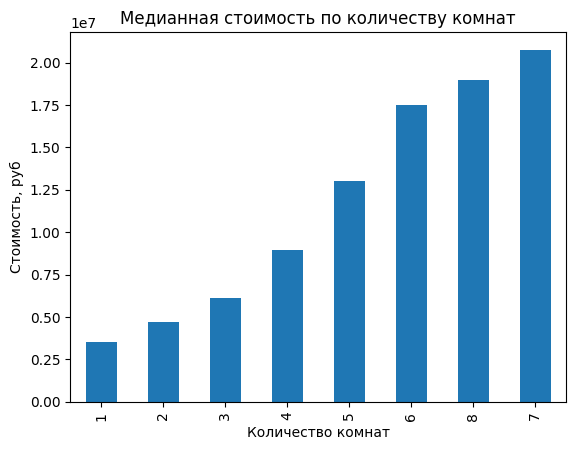

In [70]:
df.groupby('floor_kind')['last_price'].apply('median').sort_values().plot(kind='bar')
plt.xlabel(None)
plt.ylabel('Стоимость, руб')
plt.title('Медианная стоимость по категориям этажей')
plt.show()

df.groupby('rooms')['last_price'].apply('median').sort_values().plot(kind='bar')
plt.xlabel('Количество комнат')
plt.ylabel('Стоимость, руб')
plt.title('Медианная стоимость по количеству комнат')
plt.show()

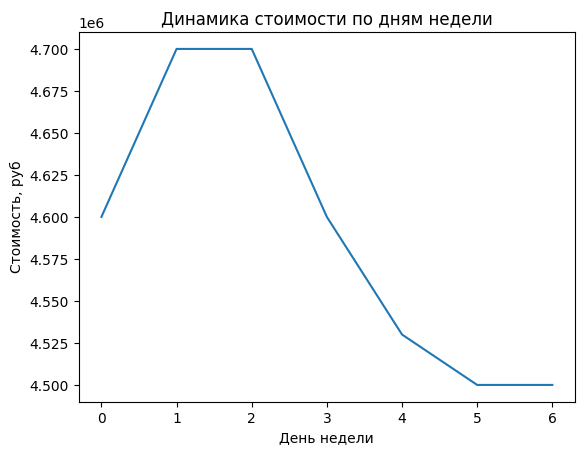

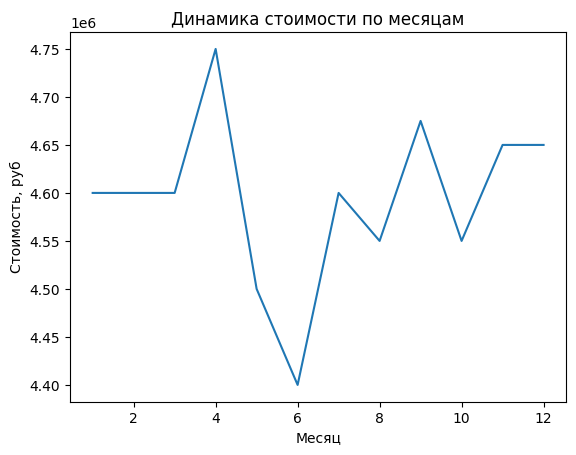

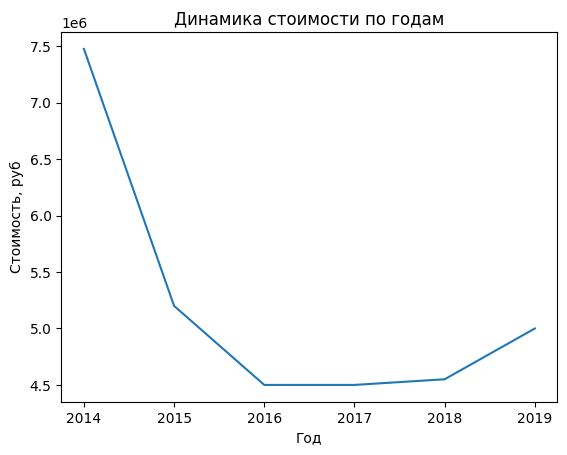

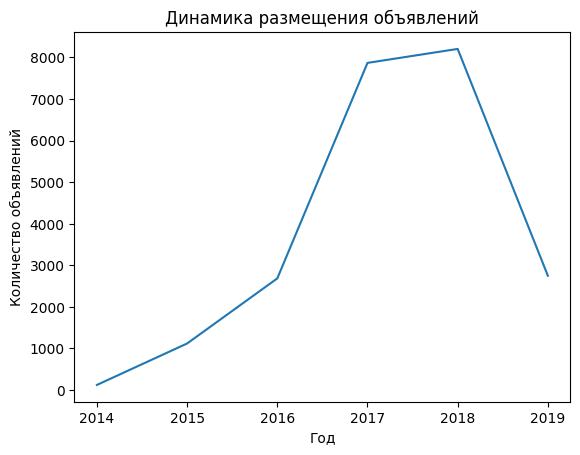

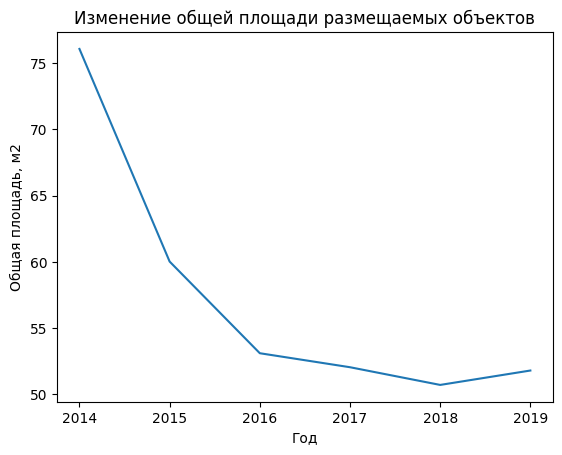

In [71]:
df.groupby('weekday_exposition')['last_price'].apply('median').plot()
plt.xlabel('День недели')
plt.ylabel('Стоимость, руб')
plt.title('Динамика стоимости по дням недели')
plt.show()

df.groupby('month_exposition')['last_price'].apply('median').plot()
plt.xlabel('Месяц')
plt.ylabel('Стоимость, руб')
plt.title('Динамика стоимости по месяцам')
plt.show()

df.groupby('year_exposition')['last_price'].apply('median').plot()
plt.xlabel('Год')
plt.ylabel('Стоимость, руб')
plt.title('Динамика стоимости по годам')
plt.show()

df.groupby('year_exposition')['last_price'].apply('count').plot()
plt.xlabel('Год')
plt.ylabel('Количество объявлений')
plt.title('Динамика размещения объявлений')
plt.show()

df.groupby('year_exposition')['total_area'].apply('median').plot()
plt.xlabel('Год')
plt.ylabel('Общая площадь, м2')
plt.title('Изменение общей площади размещаемых объектов')
plt.show()

Закодируем обозначение этажа в отдельных столбцах, чтобы найти коэффициенты корреляции со стоимостью:

In [72]:
df['floor_first'] = df.floor_kind.apply(lambda x: 1 if x == 'первый' else 0)
df['floor_last'] = df.floor_kind.apply(lambda x: 1 if x == 'последний' else 0)
df['floor_other'] = df.floor_kind.apply(lambda x: 1 if x == 'другой' else 0)

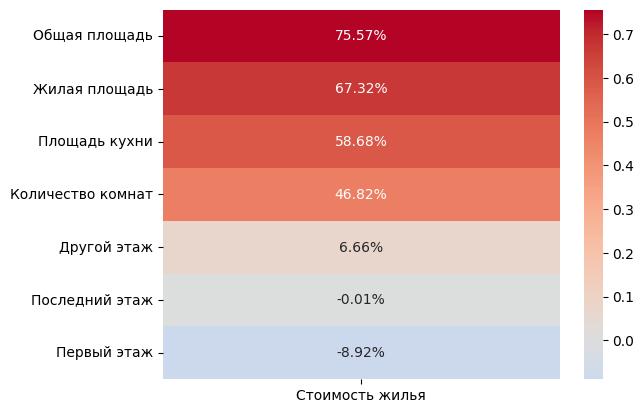

In [73]:
numerical_cols = [
                 'last_price',
                 'total_area',
                 'rooms',
                 'living_area',
                 'kitchen_area',
                 'floor_first',
                 'floor_last',
                 'floor_other'
]


price_corr_table = (
                    df[numerical_cols]
    .corr()
    .loc['last_price', :]
    .to_frame()
    .rename(columns={'last_price':'Стоимость жилья'},
                       index={'total_area':'Общая площадь',
                              'living_area':'Жилая площадь',
                              'kitchen_area':'Площадь кухни',
                              'rooms':'Количество комнат',
                              'floor_first':'Первый этаж',
                              'floor_last':'Последний этаж',
                              'floor_other':'Другой этаж'
                              })
    .loc['Общая площадь':,:]
    .sort_values(by='Стоимость жилья', 
                 ascending=False)
)

sns.heatmap(price_corr_table, annot=True, fmt='.2%', cmap='coolwarm', center=0);

#### **Вывод**

- На основании построенных зависимостей можно утверждать об уверенной корреляции между ценой и общей площадью, жилой площадью и площадью кухни объекта: с ростом этих показателей растет и цена
- Наименее ценными считаются квартиры на первом этаже, несколько более ценными квартиры на последнем этаже, а наибольшей ценой обладают квартиры на промежуточных этажах
- С ростом количества комнат увеличивается и цена
- Во вторник и среду, в среднем, размещаются самые дорогие объекты, четверг, пятница и суббота демонстрируют резкое снижение стоимости с выходом на плато в выходные, в понедельник цена поднимается до среднего показателя по неделе
- Апрель и сентябрь, в среднем, месяцы с самыми дорогими объектами. В мае фиксируется резкий спад стоимости, продолжающийся и в июне. Остальные месяцы примерно на одном уровне среднего показателя по году
- C 2014 по 2016 год заметен резкий спад средней стоимости объектов, вероятно, связанный с таким же резким спадом средней площади. С 2016 по 2018 год стоимость практически не менялась, виден незначительный рост, это происходит на фоне продолжающегося снижения средней площади (менее интенсивного, чем в период 2014-2016), которое, по всей видимости, скомпенсировано взрывным ростом количества объявлений. Резкое снижение количества объявлений в 2019 году, вероятно, объясняется датой составления выгрузки архива данных: максимальная дата -- это май 2019, т.е. данные по 2019 году неполные; этим же объясняется рост средней стоимости объектов: отсутствие провала мая и июня

### Стоимость квадратного метра по населенным пунктам

Найдем 10 населенных пунктов с наибольшим количеством объявлений (Топ-10):

In [74]:
top_10 = (df.groupby('locality_name', as_index=False)['last_price'] # группируем по названию, выводим один столбец; столбец 'last_price' точно у всех заполнен
    .count() # считаем количество
    .sort_values(by='last_price', ascending=False) # сортируем по убыванию
    .head(10) # извлекаем первые 10
    .reset_index(drop=True)
    .rename(columns={'last_price':'ads_count'})
         )
top_10

,locality_name,ads_count
0,Санкт-Петербург,15036
1,поселок Мурино,526
2,поселок Шушары,425
3,Всеволожск,389
4,Пушкин,352
5,Колпино,337
6,поселок Парголово,307
7,Гатчина,302
8,деревня Кудрово,284
9,Выборг,228


Найдем среднюю стоимость квадратного метра для каждого населенного пункта в Топ-10 и отсортируем по убыванию:

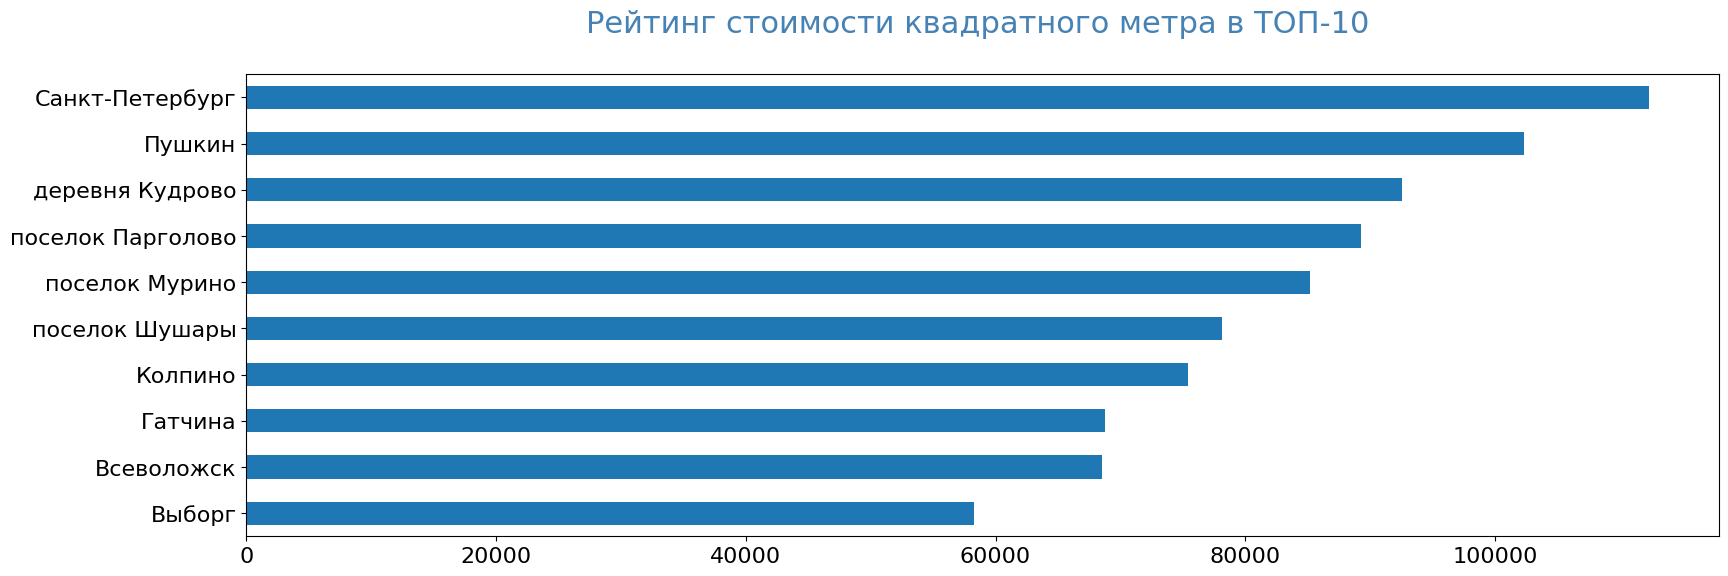

In [75]:
top_10_values = (
df.query('locality_name in @top_10.locality_name.tolist()')
    .groupby('locality_name')['sq_meter_price']
    .mean()
    .sort_values(ascending=True)
)

fig, ax = plt.subplots()
fig.set_size_inches(19, 6)
ax = top_10_values.plot(kind = 'barh',
                   rot = 0, 
                   legend = False, 
                   fontsize = 16, 
                   grid = False);
ax.set_title('Рейтинг стоимости квадратного метра в ТОП-10 \n', 
            fontsize = 22, 
            color = 'SteelBlue');
ax.set(ylabel=None);

#### **Вывод**

Из десяти населенных пунктов с наибольшим количеством объявлений самая высокая стомость квадратного метра в Санкт-Петербурге, а самая низкая в Выборге.

### Средняя стоимость километра от центра в Санкт-Петербурге

In [76]:
df['cityCenters_price_per_km'] = df['sq_meter_price'] / df['cityCenters_nearest'] * 1000

spb_avg_sq_m_per_km_price = df.query('locality_name == "Санкт-Петербург" ')['cityCenters_price_per_km'].mean()
print('Средняя стоимость квадратного метра при приближении к центру на километр в Санкт-Петербурге, руб:')
print(f'{spb_avg_sq_m_per_km_price:.0f}')

Средняя стоимость квадратного метра при приближении к центру на километр в Санкт-Петербурге, руб:
15354


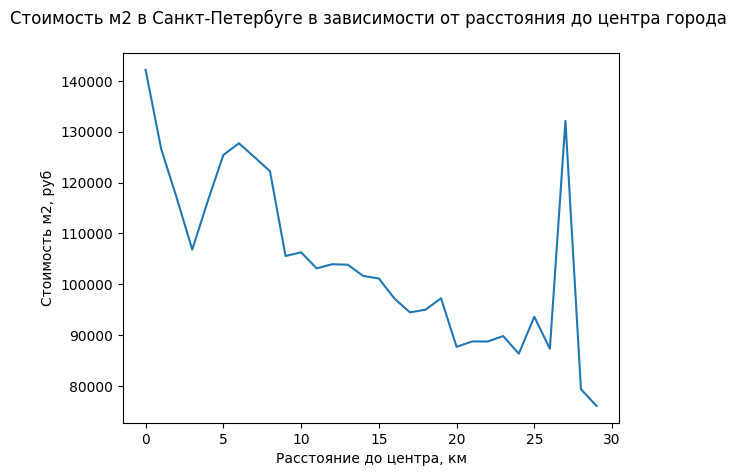

In [77]:
df[df['locality_name'] == 'Санкт-Петербург'].groupby('cityCenters_nearest_km')['sq_meter_price'].median().plot()
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Стоимость м2, руб')
plt.title('Стоимость м2 в Санкт-Петербуге в зависимости от расстояния до центра города \n')
plt.show()

Изучим выброс на 27-ом километре подробнее:

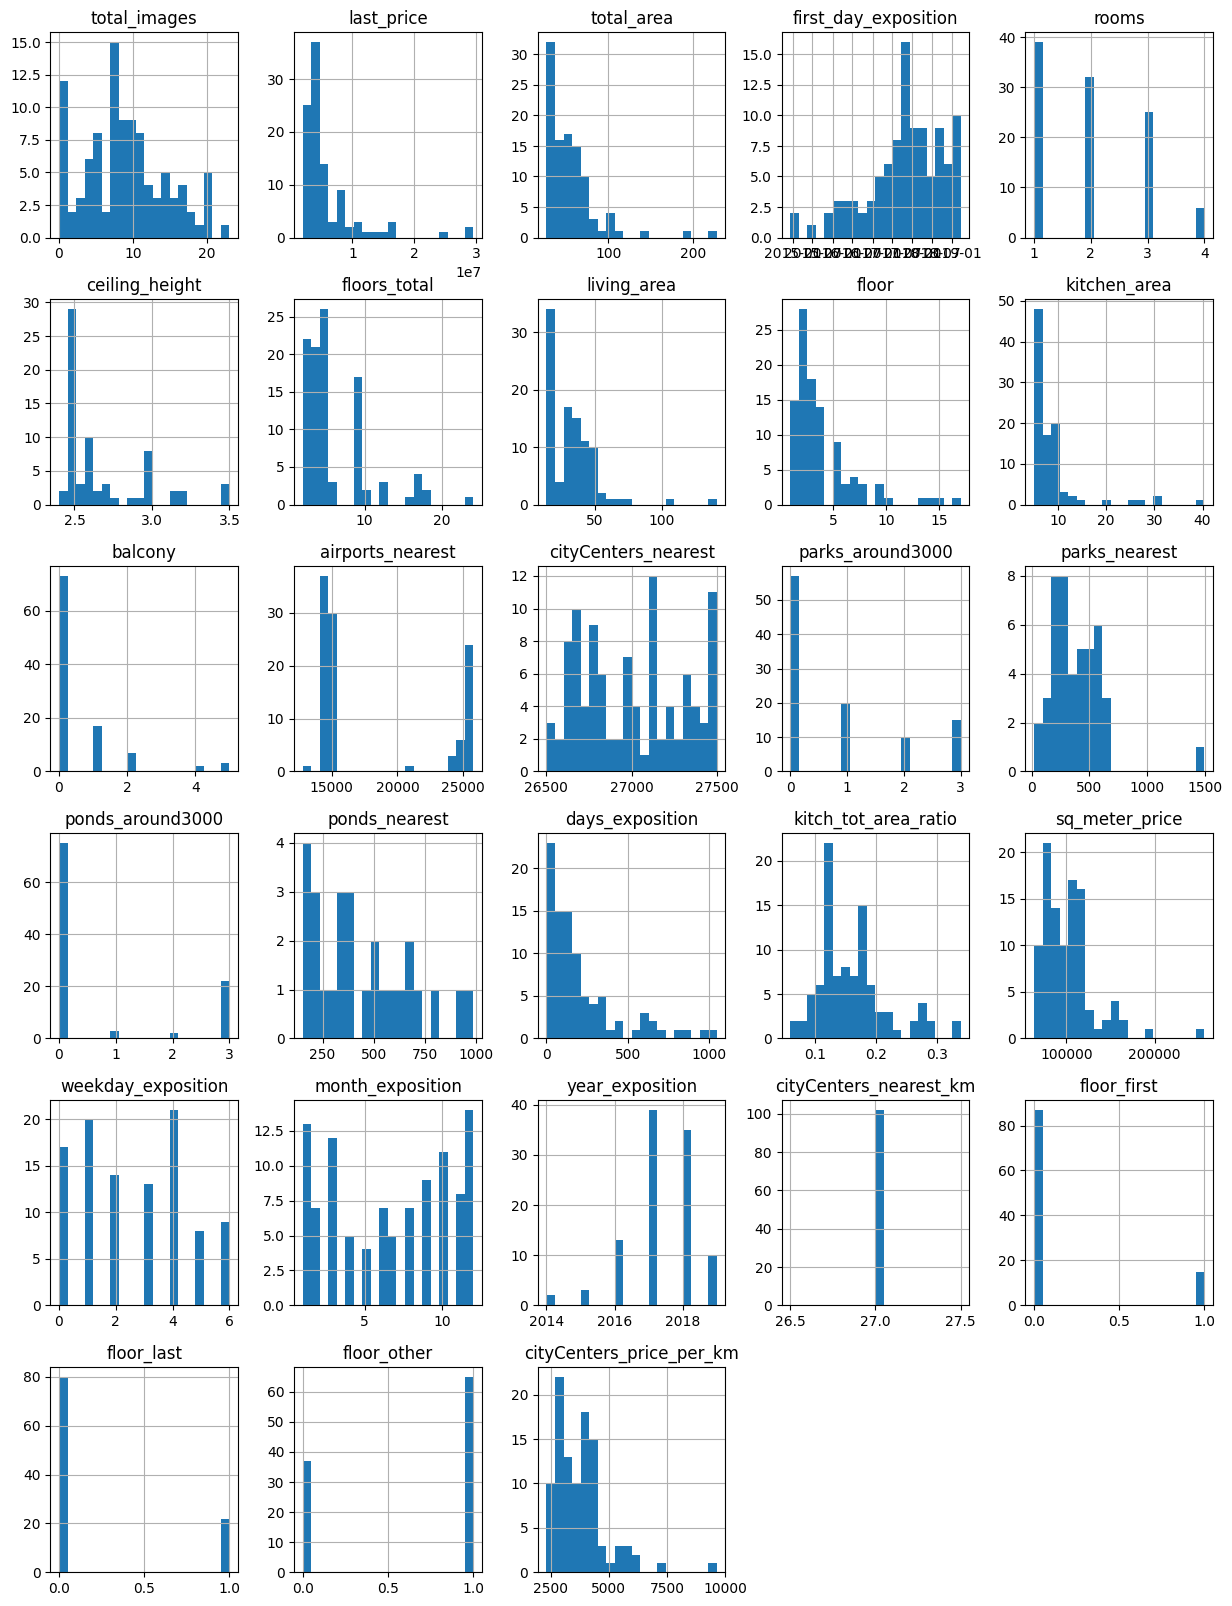

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,sq_meter_price,weekday_exposition,month_exposition,year_exposition,cityCenters_nearest_km,floor_kind,floor_first,floor_last,floor_other,cityCenters_price_per_km
2414,20,29500000,115.00,2017-07-21,3,3.00,2,69.75,2,NaN,...,"256,521.74",4,7,2017,27.00,последний,0,1,0,"9,640.41"
748,13,14350000,74.00,2017-11-28,2,3.13,5,30.00,3,NaN,...,"193,918.92",1,11,2017,27.00,другой,0,0,1,"7,099.88"
12466,11,15000000,89.60,2017-01-31,3,NaN,3,57.00,3,NaN,...,"167,410.71",1,1,2017,27.00,последний,0,1,0,"6,150.74"
140,8,16912000,105.70,2016-12-09,2,2.70,3,48.40,1,NaN,...,"160,000.00",4,12,2016,27.00,первый,1,0,0,"6,036.37"
15578,20,16000000,101.90,2018-01-08,2,2.87,4,48.10,1,NaN,...,"157,016.68",0,1,2018,27.00,первый,1,0,0,"5,739.96"
7996,17,16600000,106.00,2017-12-02,4,3.20,3,50.00,3,NaN,...,"156,603.77",5,12,2017,27.00,последний,0,1,0,"5,805.30"
4400,4,12300000,78.65,2017-09-09,3,NaN,5,48.00,1,NaN,...,"156,389.07",5,9,2017,27.00,первый,1,0,0,"5,852.88"
2948,23,11350000,75.00,2017-08-15,3,3.50,2,52.70,2,NaN,...,"151,333.33",1,8,2017,27.00,последний,0,1,0,"5,505.03"
21680,9,9300000,64.00,2016-02-12,2,3.00,6,38.00,2,False,...,"145,312.50",4,2,2016,27.00,другой,0,0,1,"5,413.02"
10162,11,8000000,56.79,2017-10-01,2,NaN,5,32.08,5,NaN,...,"140,869.87",6,10,2017,27.00,последний,0,1,0,"5,281.96"


In [78]:
df.query('cityCenters_nearest_km == 27').hist(figsize=(15, 20), bins=20);
plt.show()
df.query('cityCenters_nearest_km == 27').sort_values(by='sq_meter_price', ascending=False).head(20)

Судя по расстоянию от центра и от аэропорта Пулково, эти объявления соответствуют элитным пригородным районам Санкт-Петербурга 

Рассмотрим распределение квартир по категории этажа на 3-м и 5-м километре:

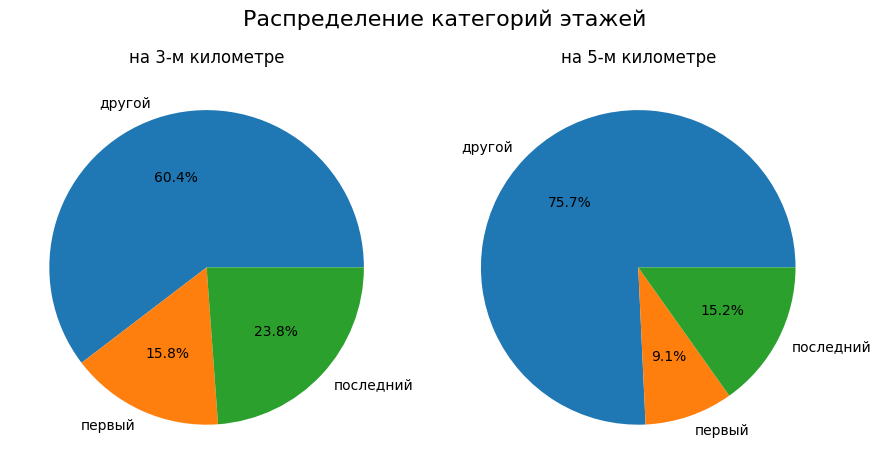

In [79]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(9, 5)
fig.suptitle('Распределение категорий этажей', fontsize=16)
fig.set(tight_layout=True)

spb_3_km = (df
 .query('cityCenters_nearest_km == 3 and locality_name == "Санкт-Петербург" ')
 .groupby('floor_kind')['last_price']
 .count()
 .to_frame())

spb_5_km = (df
 .query('cityCenters_nearest_km == 5  and locality_name == "Санкт-Петербург" ')
 .groupby('floor_kind')['last_price']
 .count()
 .to_frame())

ax[0].pie(spb_3_km.last_price, labels=spb_3_km.index, autopct='%1.1f%%' 
       )

ax[1].pie(spb_5_km.last_price, labels=spb_5_km.index, autopct='%1.1f%%'
       )

ax[0].set(ylabel=None, title='на 3-м километре')
ax[1].set(ylabel=None, title='на 5-м километре')

plt.show()

Провал и рост на 3-м и 5-м километре соответственно объясняется изменением соотношения категорий фонда: на 3-м километре более широко представлены категории этажа `первый` и `последний`, которые имеют меньшую стоимость в сравнении с категорией `другой`

#### **Вывод**
- Проведенный анализ показывает, что с увеличением расстояния до центра города цена квартир в Санкт-Петербурге снижается
- Стоимость сокращения расстояния до центра города на один километр составляет в среднем `15300` руб / м<sup>2</sup>

## **Общий вывод**

**Общие сведения**
- Использованный массив данных -- это архив сервиса Яндекс Недвижимость за несколько лет по Санкт-Петербургу и ближайшим населенным пунктам. Массив данных передан в виде файла типа .csv и содержит параметры, заданные пользователями (стоимость, этаж, площадь и др.), а также картографические параметры (расстояние до центра города, наличие поблизости парков и др.)
- Исходный датафрейм имел 22 столбца и ~ 24 тыс. строк

**Предобработка данных**
- Датафрейм необходимо было предобработать: часть столбцов с пропусками, а некоторые столбцы имели не самый удачный тип данных
  
  
- В ходе проведенной предобработки данных выявлены пропуски значений, некорректные типы данных, неявные дубликаты в названиях и аномальные значения в столбцах

- Пропуски в данных заполнили следующим образом: 
    - В показателе количества балконов пропуски заполнены нулями
    - Пропуски в общем количестве этажей удалены
    - Оставшиеся показатели без изменений: введенные пользователями параметры не показали адекватной корреляции друг с другом для заполнения на их основе, а картографические показатели заполнить не представляется возможным


- Тип данных в столбцах `floors_total` `last_price` и `balcony` изменены с `float` на `int`. В столбце `first_day_exposition` c `object` на `datetime`
    - Эти изменения позволят более рационально использовать ресурсы оперативной памяти и ускорит работу с данными, в случае с датой это также значительно увеличит удобство работы


- Ликвидировали неявные дубликаты названий населенных пунктов (например 'посёлок' - 'поселок') путем замены на одно общее название


- Аномальные значения выявлены в столбцах `ceiling_height`, `living_area`, `kitchen_area`, `rooms`, `total_area`, `days_exposition`, `last_price`, `floors_total`
    - Высота потолков в диапазоне `22 - 38` метров уменьшена в `10` раз, оставшиеся строки со значениями за пределами `2.2 - 3.8` метров удалены как некорректные
    - Удалены строки со значениями жилой площади, превышающей общую
    - Проведен статистический анализ соотношения жилой площади и общей площади в выборке, строки с аномально низкими и аномально высокими соотношениями удалены. Подобный анализ проведен для площади кухни относительно общей площади, аномальные строки удалены
    - Оставшиеся данные очищены от значений за пределами `0,9976` квантилей, как малочисленные и выбивающиеся из общей выборки 

- Изначальный массив данных составлял `23699` строк, после предобработки составил `22743` строк
- Удалено ~ `4 %` данных
- Внесенные изменения улучшили качество данных, на их основании удалось сделать более уверенные выводы

**Расчет вспомогательных показателей**

Рассчитаны следующие величины:

- Цена одного квадратного метра
- День недели публикации объявления
- Месяц публикации объявления
- Год публикации объявления
- Тип этажа квартиры (первый, последний, другой)
- Расстояние до центра города в километрах

**Анализ данных**


- В выборке, в основном, представлены обычные квартиры: пяти или девятиэтажные здания, от одной до трех комнат типичного размера

- Чаще всего объявления размещают по будним дням, а самый популярный период года для размещения -- три месяца -- февраль, март, апрель


**Скорость продажи объектов**

- Типичное время продажи характеризуется медианой: `95` дней

- Быстрыми продажами можно назвать те, у которых время продажи меньше или равно `45` дням, таких продаж только `25 %` (первый квартиль)

- Необычно долгое время достигается при превышении `229` дней, поскольку `75 %` продаж осуществляются быстрее (третий квартиль)



**Связь между ценой и показателями исходного массива данных**


- На основании построенных зависимостей можно утверждать об уверенной корреляции между ценой и общей площадью, жилой площадью и площадью кухни объекта: с ростом этих показателей растет и цена
- Наименее ценными считаются квартиры на первом этаже, несколько более ценными квартиры на последнем этаже, а наибольшей ценой обладают квартиры на промежуточных этажах
- С ростом количества комнат увеличивается и цена
- Во вторник и среду, в среднем, размещаются самые дорогие объекты, четверг, пятница и суббота демонстрируют резкое снижение стоимости с выходом на плато в выходные, в понедельник цена поднимается до среднего показателя по неделе
- Апрель и сентябрь, в среднем, месяцы с самыми дорогими объектами. В мае фиксируется резкий спад стоимости, продолжающийся и в июне. Остальные месяцы примерно на одном уровне среднего показателя по году
- C 2014 по 2016 год заметен резкий спад средней стоимости объектов, вероятно, связанный с таким же резким спадом средней площади. С 2016 по 2018 год стоимость практически не менялась, виден незначительный рост, это происходит на фоне продолжающегося снижения средней площади (менее интенсивного, чем в период 2014-2016), которое, по всей видимости, скомпенсировано взрывным ростом количества объявлений. Резкое снижение количества объявлений в 2019 году, вероятно, объясняется датой составления выгрузки архива данных: максимальная дата -- это май 2019, т.е. данные по 2019 году неполные; этим же объясняется рост средней стоимости объектов: отсутствие провала мая и июня
    
**Связь между ценой и вспомогательными показателями**    
- Из десяти населенных пунктов с наибольшим количеством объявлений самая высокая стомость квадратного метра в Санкт-Петербурге, а самая низкая в Выборге


- Проведенный анализ показывает, что с увеличением расстояния до центра города цена квартир в Санкт-Петербурге снижается
- Стоимость сокращения расстояния до центра города на один километр составляет в среднем `15300` руб / м<sup>2</sup>

**Основные рекомендации**  

- Рекомендуем прогнозировать цену на объект исходя из его площади, при этом с ростом площади растет и цена
- Имеет смысл ввести три категории этажа объекта: наименее ценны квартиры на первом этаже, следующими следуют квартиры на последнем этаже, самые дорогие квартиры на промежуточных этажах
- Увеличение количества комнат однозначно увеличивает стоимость объекта
- Рекомендуем ввести ранги для населенных пунктов, проведенный анализ показал разницу в цене за квадратный метр в разных городах
- Предлагаем учитывать сезонность при прогнозах, однако, необходимо подходить к этому комплексно: нельзя утверждать наверняка, что факторы сезонности напрямую влияют на реальную стоимость объектов
- Наконец, имеет смысл учитывать расстояние до центра города в крупных городах: чем ближе к центру, тем дороже объект
- В дополнение, рекомендуем предлагать пользователю снизить цену для ускорения продажи при превышении `229` дней размещения, это потенциально может увеличить лояльность пользователей

**Рекомендации к сбору данных**  


- Возможно, следует автоматически заполнять значение нулем, если пользователь не выбрал количество балконов
- Рекомендуется ввести проверку на величину параметра: просить подтверждения пользователя, если введенное значение выбивается из характерного интервала (большинство объявлений не выбивается, а это решение позволит уменьшить число аномалий)
- Необходимо уточнить процесс заполнения столбца `is_apartment` -- почти все записи в исходной таблице не заполнены, вероятно проблема техническая, если это обычный чекбокс